# Analysis of minimal pairs and homophones

What we know:

1. The real lexicon is "clumpier" than artificial lexicons. (Dautriche et al, 2016)
2. The real lexicon also has a positive relationship between *number of homophones* and *number of minimal pairs* of a word.
3. The real lexicon actually recycles phonotactically-plausible words *less* than artificial lexicons. 

According to (3), it seems like the real lexicon isn't optimizing purely for phonotactic plausibility. That is, perhaps it optimizes partly for phonotactic plausibility, but also attempts to attenuate ambiguity by "spreading out" phonotactically-friendly wordforms *across* the phonological space, creating larger neighborhoods. Is this true?

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentages': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }
    

In [6]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted")

In [7]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word"):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language,
                                                                                         lan2=language))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials
    

In [8]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        params = result_fake.params
        params['real'] = "No"
        coefs.append(params)
    
    return pd.DataFrame(coefs)
    
    

In [9]:
def process_stats(df_real, list_of_fakes, formula, covariates, covariate_labels, language):
    """Pipeline for processing and plotting stats results."""
    df_stats = analyze_stats(df_real, list_of_fakes, formula=formula, covariates=covariates)
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for index, cov in enumerate(COVARIATES):
        ax = fig.add_subplot(len(COVARIATES), 1, index+1)

        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        ax.hist(art_values)
        ax.axvline(x=real_value, linestyle="dotted")
        ax.axvline(x=0, linestyle="dashed")
        ax.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)


        plt.title("{lan}: coefficient for {cov}".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))

    fig.subplots_adjust(hspace=.5)
    
    target = formula.split(" ~")[0]
    regressors = ' '.join(covariates)
    plt.savefig("Figures/{l1}/{l2}_stats_{target}_{regressors}.png".format(l1=language,
                                                                           l2=language,
                                                                           target=target,
                                                                           regressors=regressors), 
                dpi=300)
    
    # Now save individual versions

    ### Set up directories
    if not os.path.exists("Figures/{lan}/individual_plots".format(lan=language)):
        print("Figures/{lan}/individual_plots".format(lan=language))
        os.mkdir("Figures/{lan}/individual_plots".format(lan=language))
    for index, cov in enumerate(COVARIATES):
        fig = plt.figure()
        fig.set_figwidth(9)
        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        plt.hist(art_values)
        plt.axvline(x=real_value, linestyle="dotted")
        plt.axvline(x=0, linestyle="dashed")
        plt.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

        plt.title("{lan}: coefficient for {cov}".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))
        
        plt.savefig("Figures/{l1}/individual_plots/{l2}_{target}_{cov}_{regressors}.png".format(l1=language,
                                                                                   l2=language,
                                                                                   target=target,
                                                                                   cov=cov,
                                                                                   regressors=regressors), 
                    dpi=300)
        plt.close(fig)

## English

In [49]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

In [50]:
len(df_celex)

51888

In [51]:
len(df_celex_processed)

34924

In [52]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [53]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.27it/s]


In [54]:
processed_artificials = info_for_english['processed_dataframes']

### Visualizations

In [16]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [17]:
df_celex_processed['surprisal_binned'] = np.digitize(df_celex_processed['surprisal'], 
                                                     np.linspace(0,12,30,endpoint=False))

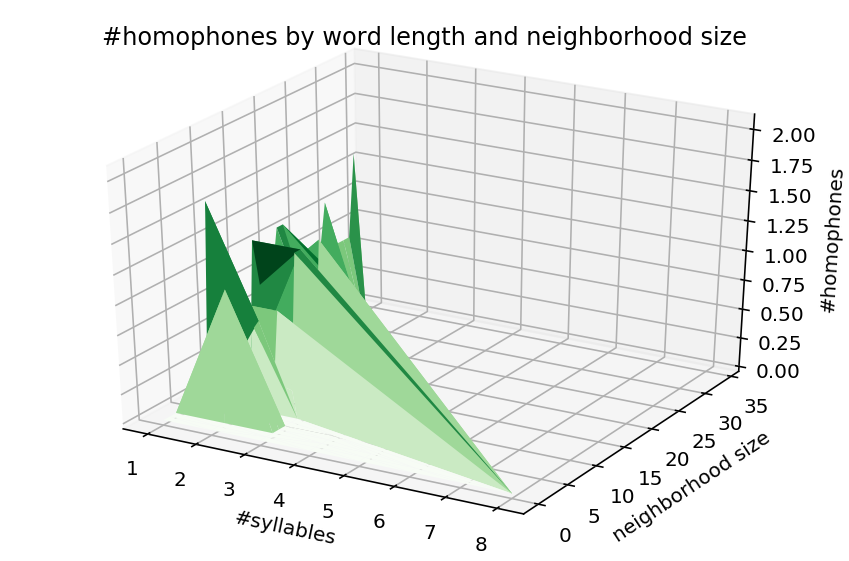

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf (df_celex_processed['num_sylls_est'], df_celex_processed['neighborhood_size'], 
                 np.log(df_celex_processed['num_homophones']+ 1), cmap='Greens');
ax.set_xlabel("#syllables")
ax.set_ylabel("neighborhood size")
ax.set_zlabel("#homophones")
plt.title("#homophones by word length and neighborhood size")
plt.tight_layout()

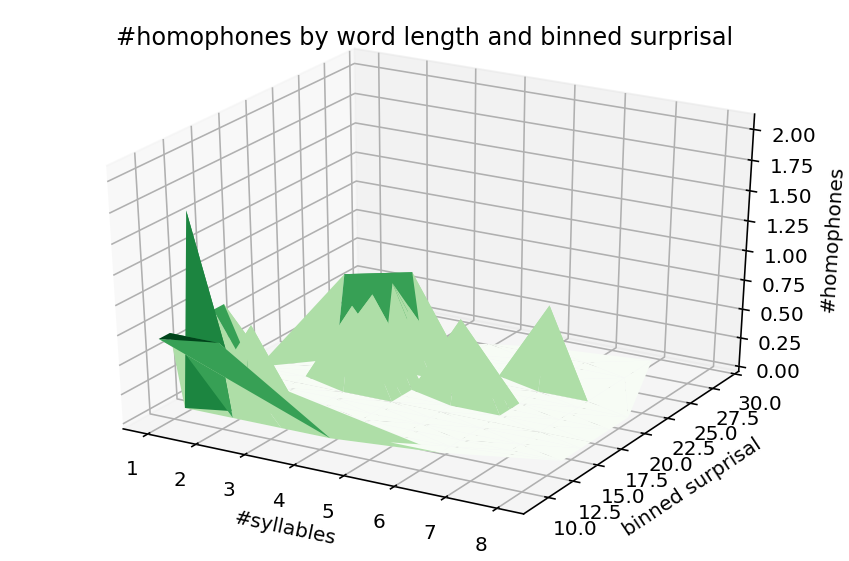

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf (df_celex_processed['num_sylls_est'], df_celex_processed['surprisal_binned'], 
                 np.log(df_celex_processed['num_homophones'] + 1), cmap='Greens');
ax.set_xlabel("#syllables")
ax.set_ylabel("binned surprisal")
ax.set_zlabel("#homophones")
plt.title("#homophones by word length and binned surprisal")
plt.tight_layout()

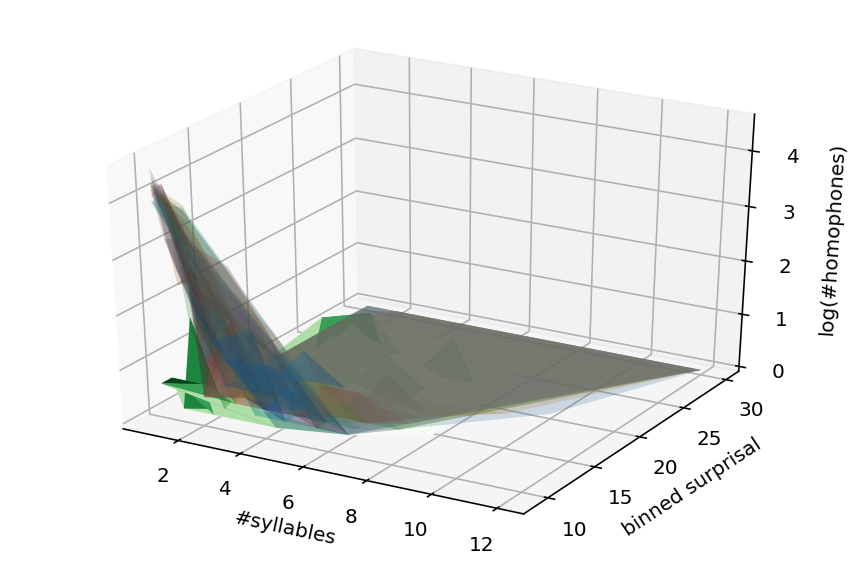

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for index, i in enumerate(processed_artificials):
    i['surprisal_binned'] = np.digitize(i['surprisal'], 
                                        np.linspace(0,12,30,endpoint=False))    
    
    ax.plot_trisurf (i['num_sylls_est'], i['surprisal_binned'], 
                     np.log(i['num_homophones'] + 1), alpha = .2);
    ax.set_xlabel("#syllables")
    ax.set_ylabel("binned surprisal")
    ax.set_zlabel("log(#homophones)")


ax.plot_trisurf (df_celex_processed['num_sylls_est'], df_celex_processed['surprisal_binned'], 
                 np.log(df_celex_processed['num_homophones']+ 1), cmap='Greens');
plt.tight_layout()

In [22]:
df_celex_processed['surprisal_binned'] = np.digitize(df_celex_processed['surprisal'], 
                                                     np.linspace(1,12,30,endpoint=False))

df_celex_processed['surprisal_binned'] = pd.cut(df_celex_processed['surprisal'], bins=20, labels=range(1, 21))

df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='surprisal_binned', 
                                          homophone_column='num_homophones')

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


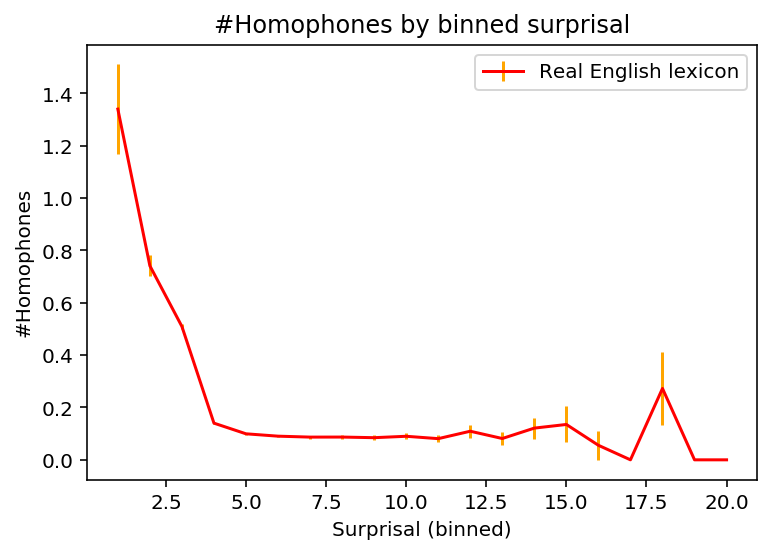

In [23]:
### First plot real
plt.title("#Homophones by binned surprisal")
plt.xlabel("Surprisal (binned)")
plt.ylabel("#Homophones")
plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
# plt.xticks(list(range(1, 10)))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
plt.legend(loc='upper right')

In [24]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):

    df_tmp_processed['surprisal_binned'] = pd.cut(df_tmp_processed['surprisal'], bins=20, labels=range(1, 21))
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='surprisal_binned', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


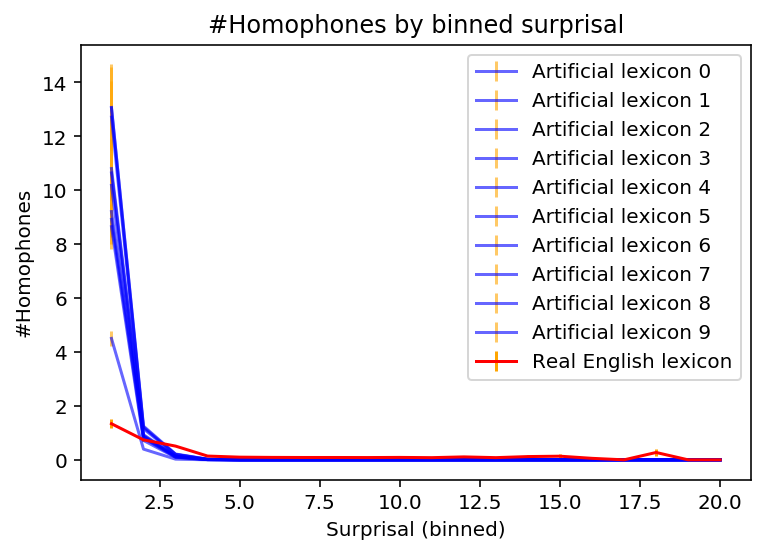

In [25]:
plt.title("#Homophones by binned surprisal")
plt.xlabel("Surprisal (binned)")
plt.ylabel("#Homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.legend(loc='upper right')

In [26]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):

    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='num_sylls_est', 
                                          homophone_column='num_homophones')

100%|██████████| 10/10 [00:00<00:00, 12.20it/s]


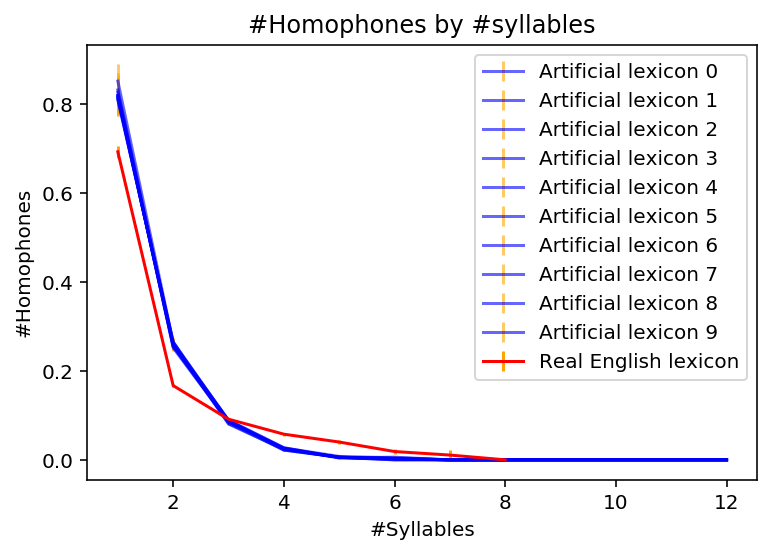

In [27]:
plt.title("#Homophones by #syllables")
plt.xlabel("#Syllables")
plt.ylabel("#Homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.legend(loc='upper right')

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), there are more minimal pairs in the real lexicon than in the artificial English lexicons, whether or not homophones are included. The same goes for the **mean** neighborhood size per word.

There are also larger **max** neighborhoods in English, but only when not counting homophones in neighborhood size. When homophones are included, the artificial lexicons have larger neighborhoods––presumably because there are much larger numbers of homophones per wordform in the artificial lexicons.

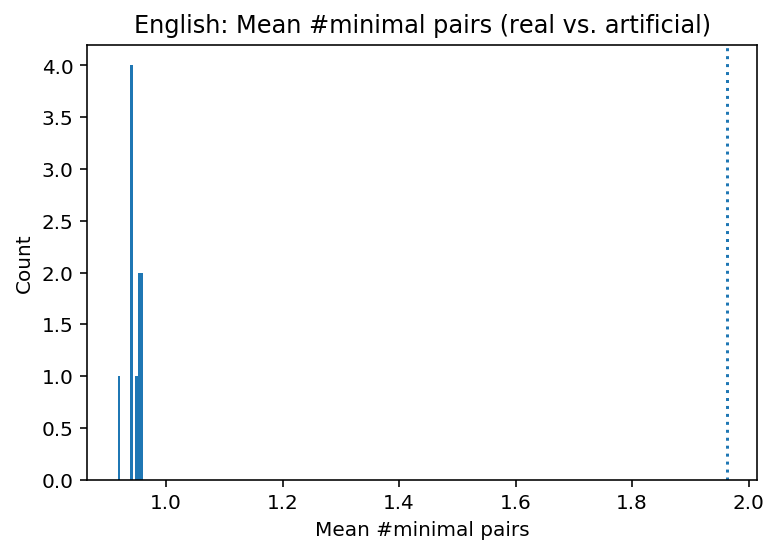

In [111]:
plot_real_vs_art(info_for_english['mean_mp'], df_english_stats['mean_mp'],
                'Mean #minimal pairs', language="English")

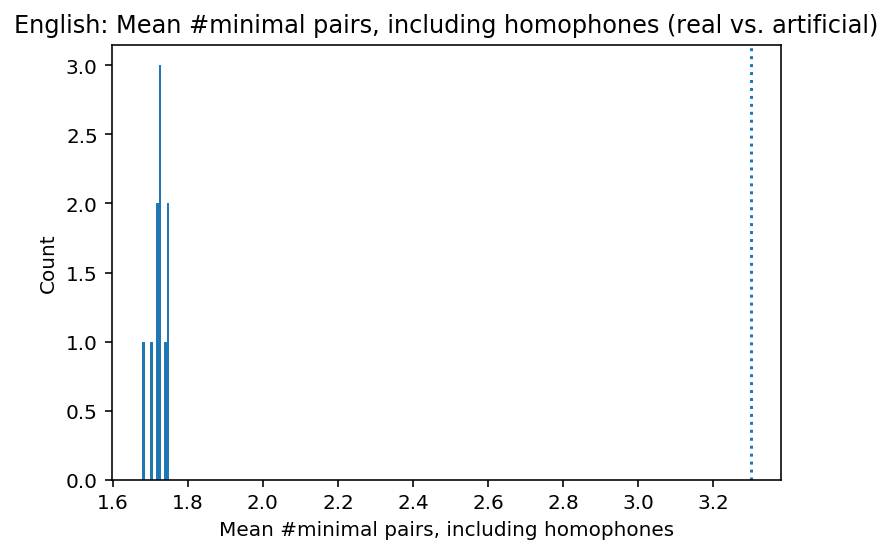

In [ ]:
plot_real_vs_art(info_for_english['mean_mp_w_hp'], df_english_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="English")

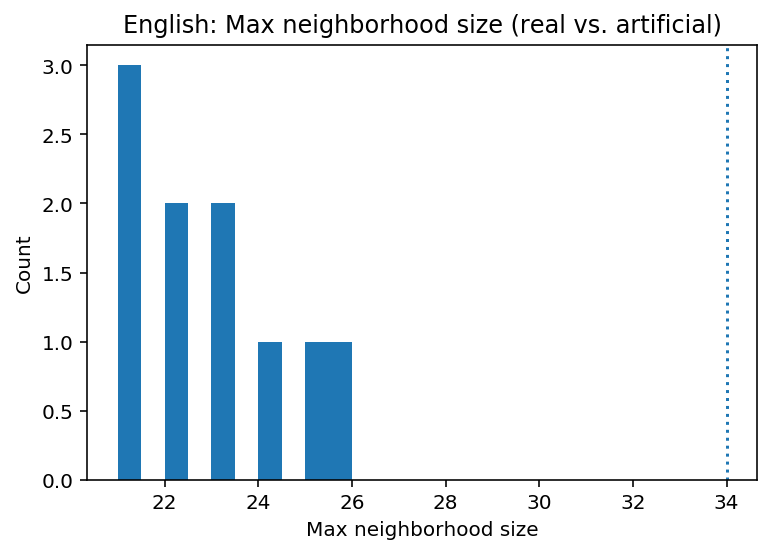

In [ ]:
plot_real_vs_art(info_for_english['max_mp'], df_english_stats['max_mp'],
                'Max neighborhood size', language="English")

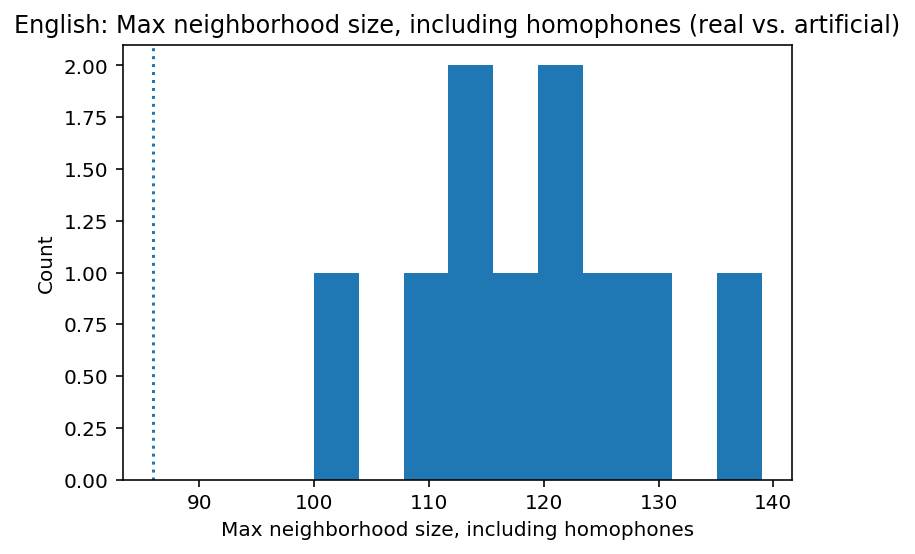

In [ ]:
plot_real_vs_art(info_for_english['max_mp_w_hp'], df_english_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="English")

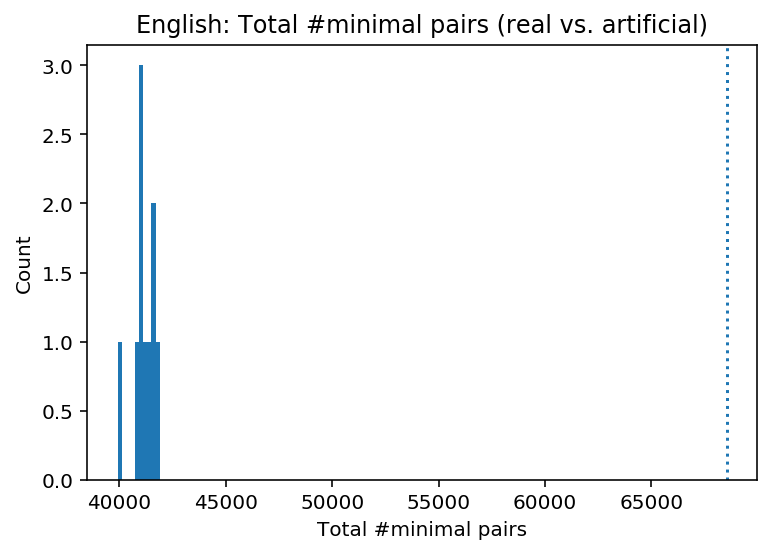

In [ ]:
plot_real_vs_art(info_for_english['total_mp'], df_english_stats['total_mp'],
                'Total #minimal pairs', language='English')

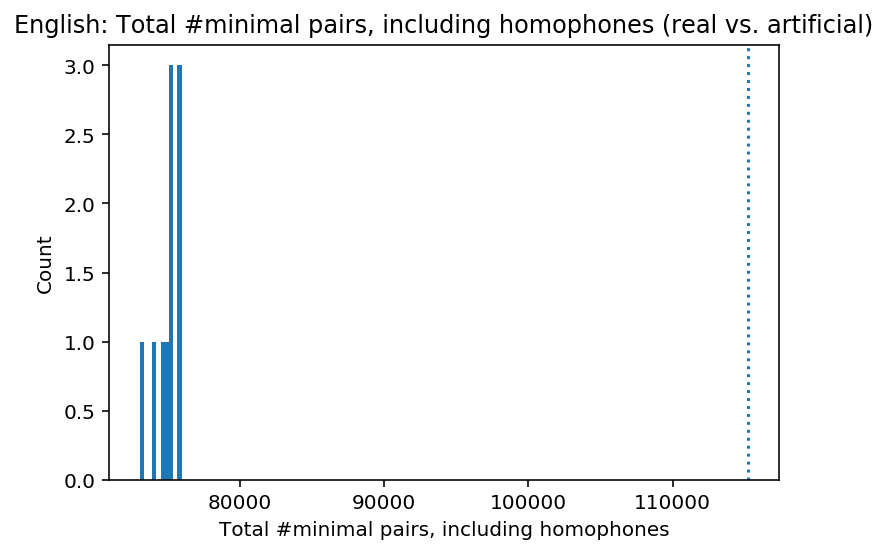

In [ ]:
plot_real_vs_art(info_for_english['total_mp_w_hp'], df_english_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='English')

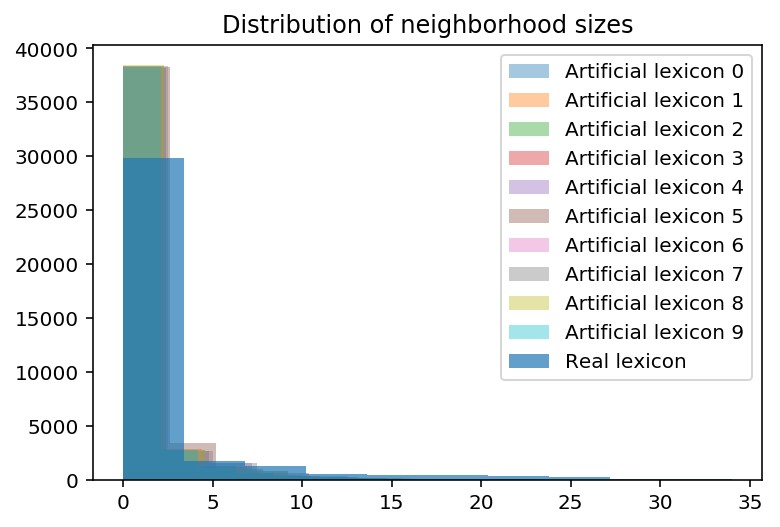

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

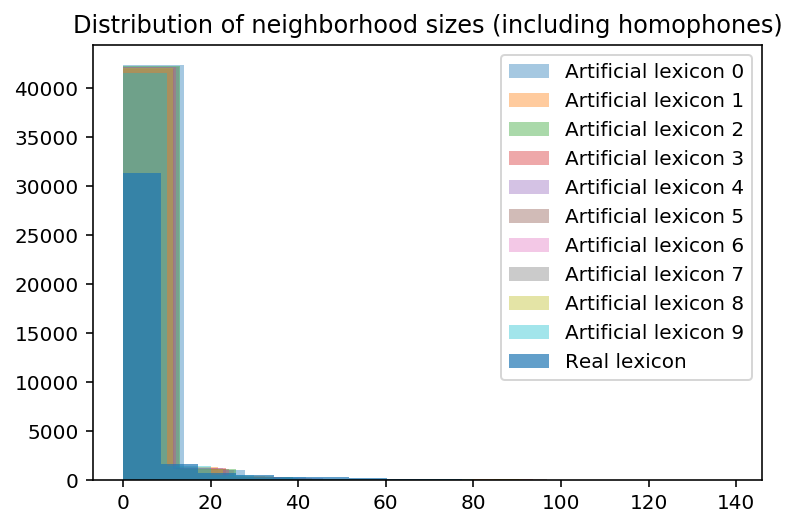

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes (including homophones)")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 80, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

On the other hand, the real English lexicon has a higher proportion of homophonous wordforms overall.

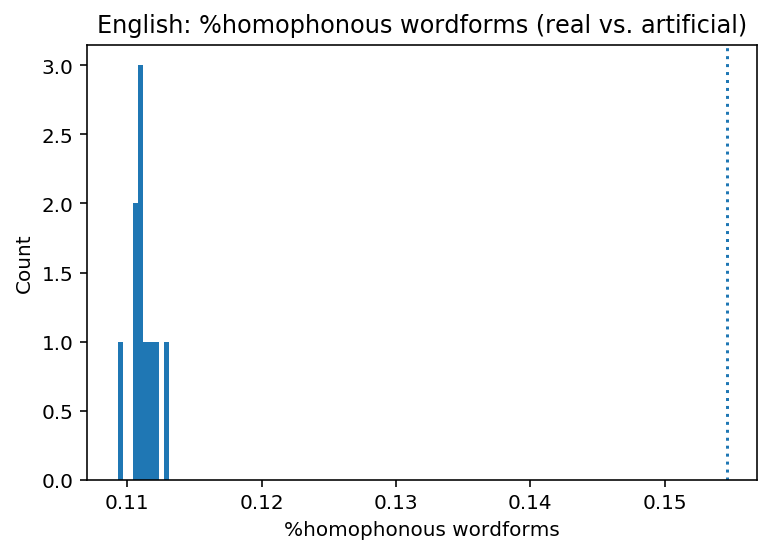

In [ ]:
plot_real_vs_art(info_for_english['homophone_percentages'], df_english_stats['homophone_percentage'],
                '%homophonous wordforms', language='English')
plt.savefig("Figures/english/english_percent_homophones.png", dpi=300)

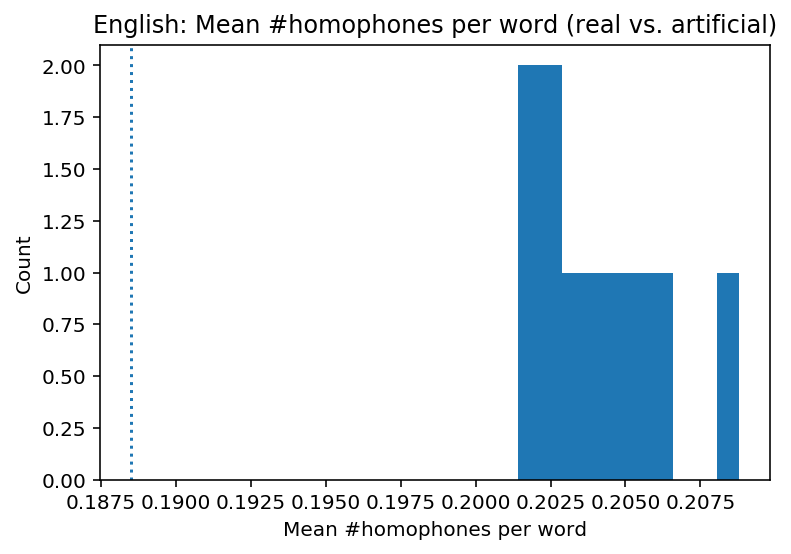

In [ ]:
plot_real_vs_art(info_for_english['mean_homophones'], df_english_stats['mean_homophones'],
                'Mean #homophones per word', language='English')
plt.savefig("Figures/english/english_mean_homophones.png", dpi=300)

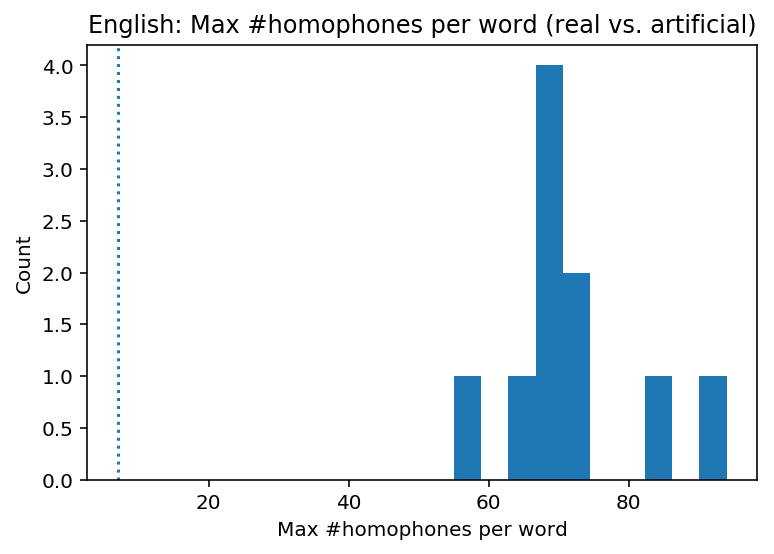

In [ ]:
plot_real_vs_art(info_for_english['max_homophones'], df_english_stats['max_homophones'],
                'Max #homophones per word', language='English')
plt.savefig("Figures/english/english_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in artificial lexicons than the real lexicon. This is in contrast to the other analysis. The difference here is that we're also factoring in neighborhood size as a covariate.
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [36]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'English'

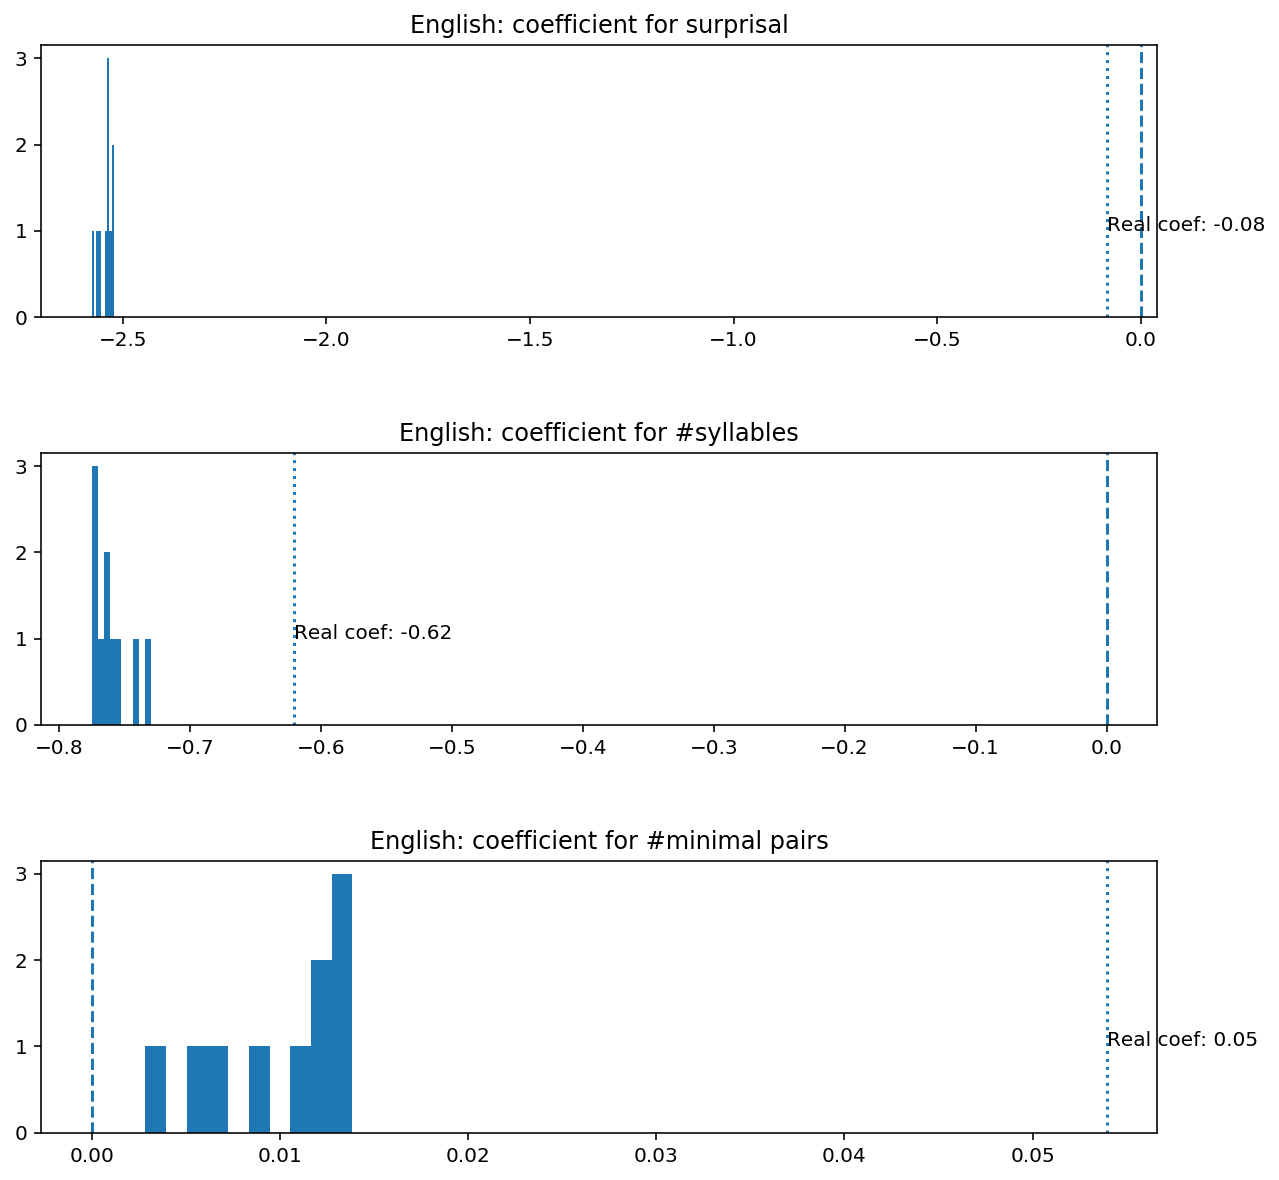

In [37]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [38]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'English'

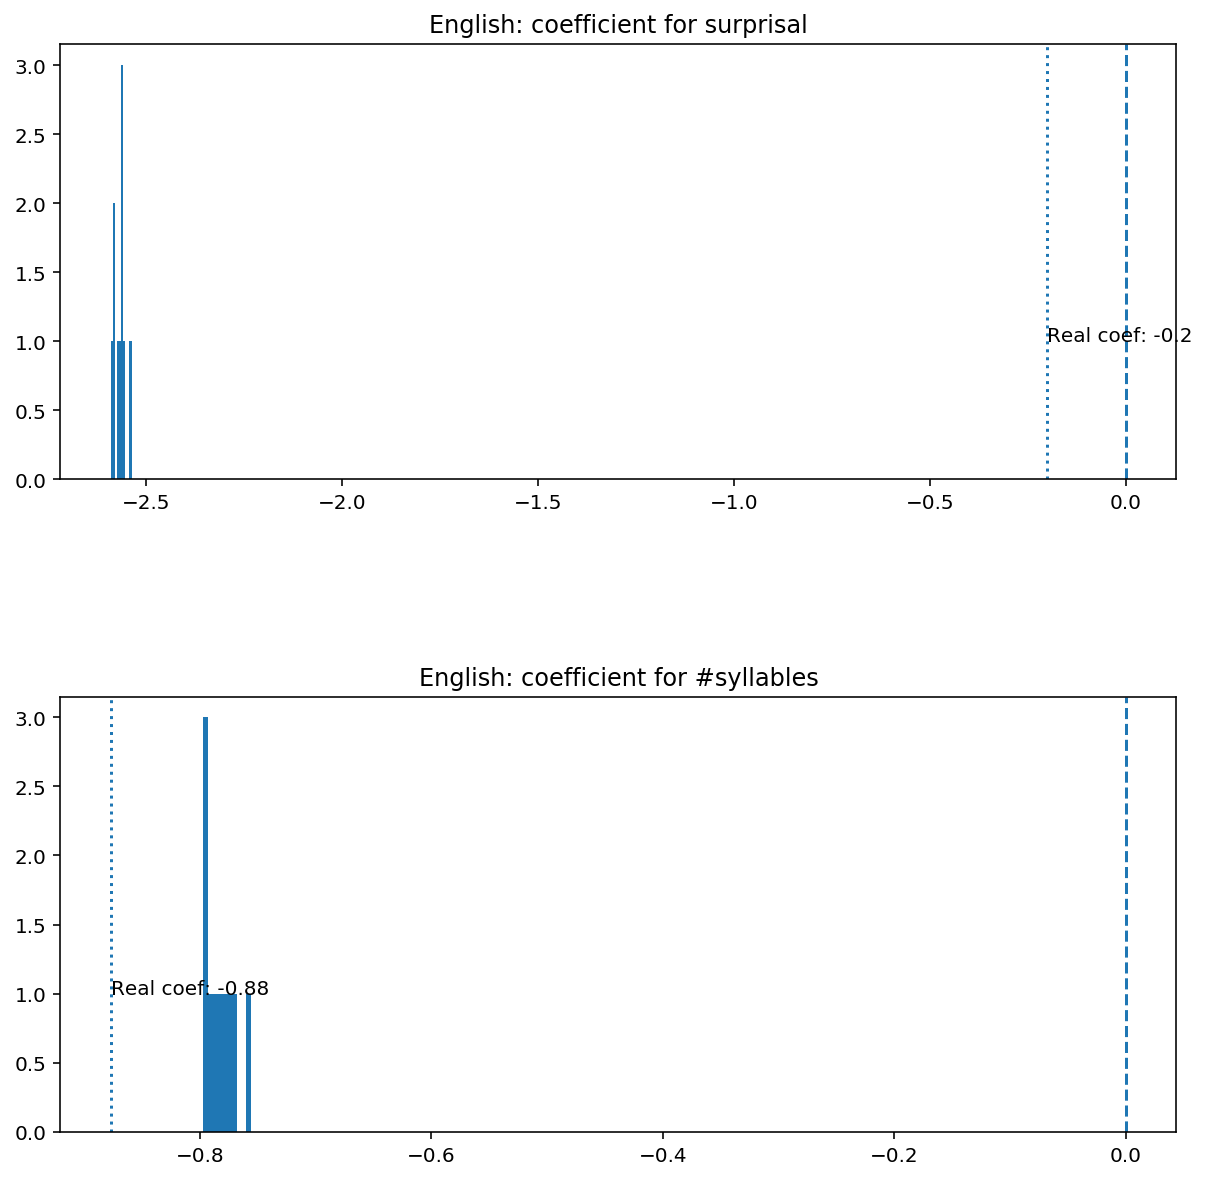

In [39]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting *neighborhood size* from number of homophones

Do words with more homophones have larger neighborhoods?

(Here, we don't do the analysis for neighborhood estimates including homophones, because this results in a singular matrix.)

#### Analysis

In [55]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
]
LANGUAGE = 'English'

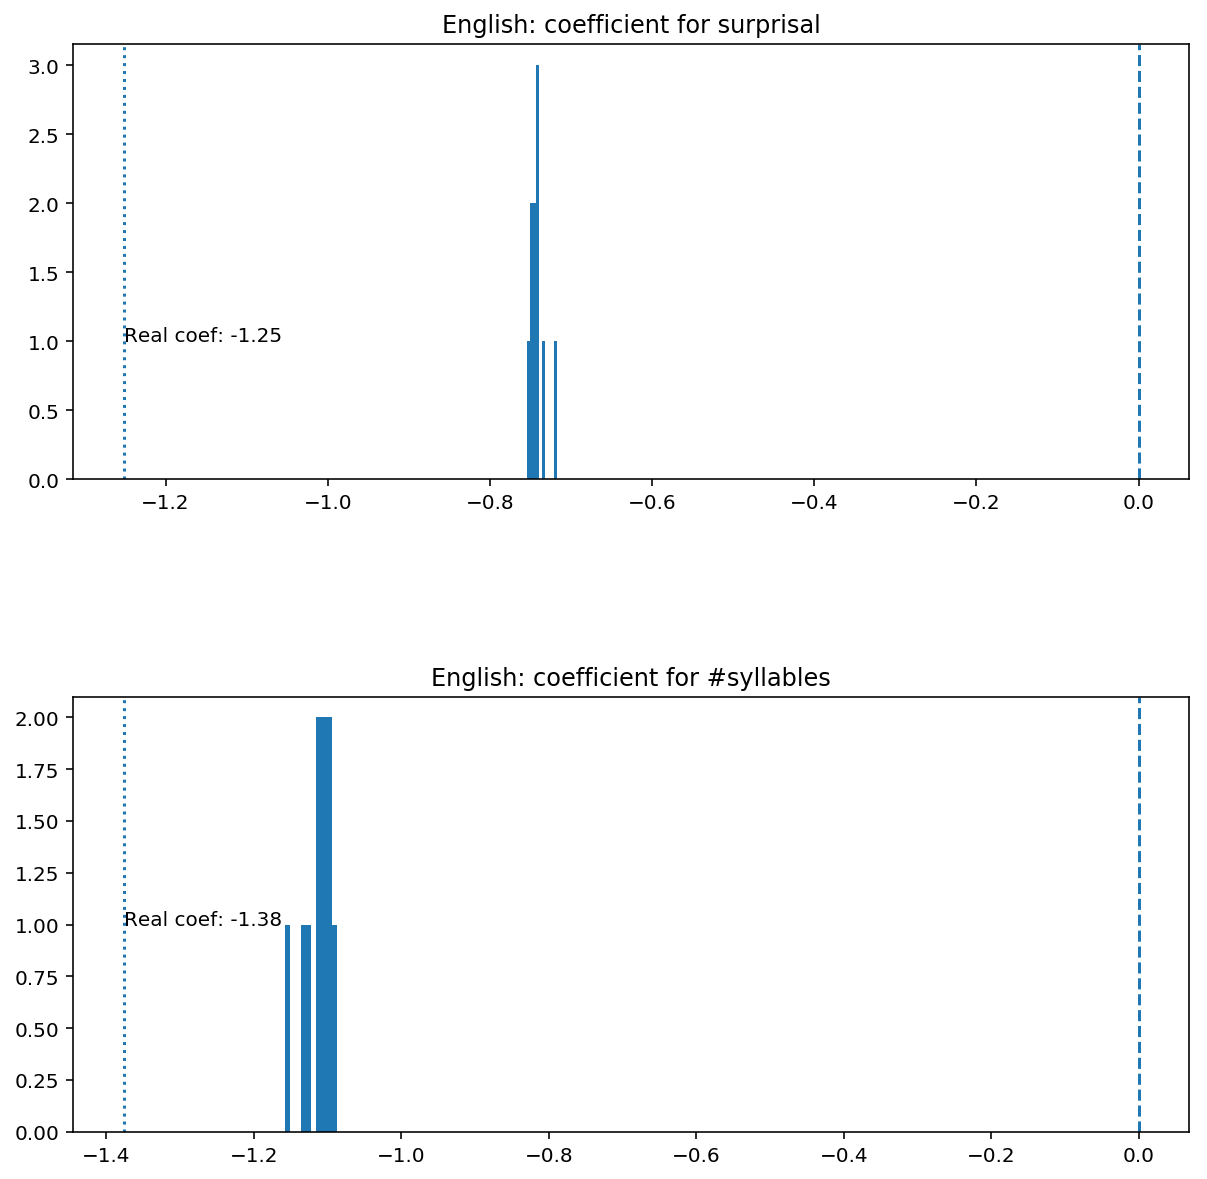

In [56]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# German

In [20]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

In [21]:
len(df_celex)

51718

In [22]:
len(df_celex_processed)

50474

In [23]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [32]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [33]:
processed_artificials = info_for_german['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

In [ ]:
plot_real_vs_art(info_for_german['mean_mp'], df_german_stats['mean_mp'],
                'Mean #minimal pairs', language="German")

In [ ]:
plot_real_vs_art(info_for_german['mean_mp_w_hp'], df_german_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="German")

In [ ]:
plot_real_vs_art(info_for_german['max_mp'], df_german_stats['max_mp'],
                'Max neighborhood size', language="German")

In [ ]:
plot_real_vs_art(info_for_german['max_mp_w_hp'], df_german_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="German")

In [ ]:
plot_real_vs_art(info_for_german['total_mp'], df_german_stats['total_mp'],
                'Total #minimal pairs', language='German')

In [ ]:
plot_real_vs_art(info_for_german['total_mp_w_hp'], df_german_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='German')

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

In [ ]:
for df_tmp in processed_artificials:
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word, and a higher percentage of homophonous wordforms overall.

In [ ]:
plot_real_vs_art(info_for_german['homophone_percentages'], df_german_stats['homophone_percentage'],
                '%homophonous wordforms', language='German')
plt.savefig("Figures/german/german_%_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_german['mean_homophones'], df_german_stats['mean_homophones'],
                'Mean #homophones per word', language='German')
plt.savefig("Figures/german/german_mean_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_german['max_homophones'], df_german_stats['max_homophones'],
                'Max #homophones per word', language='German')
plt.savefig("Figures/german/german_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (German)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [20]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'German'

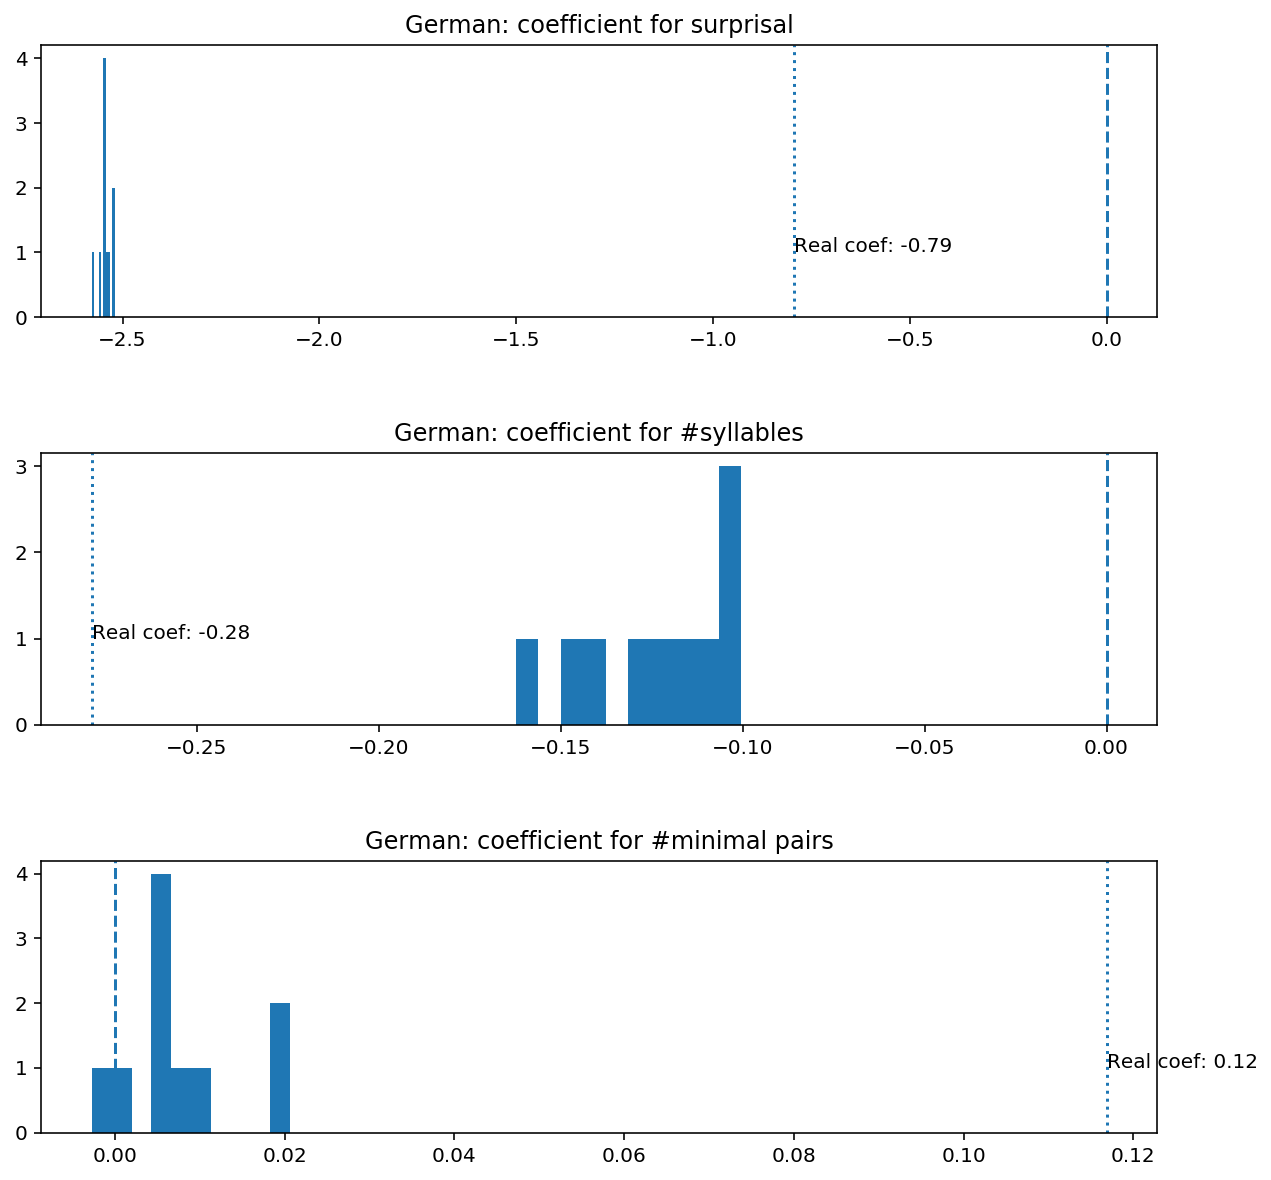

In [21]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [22]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'German'

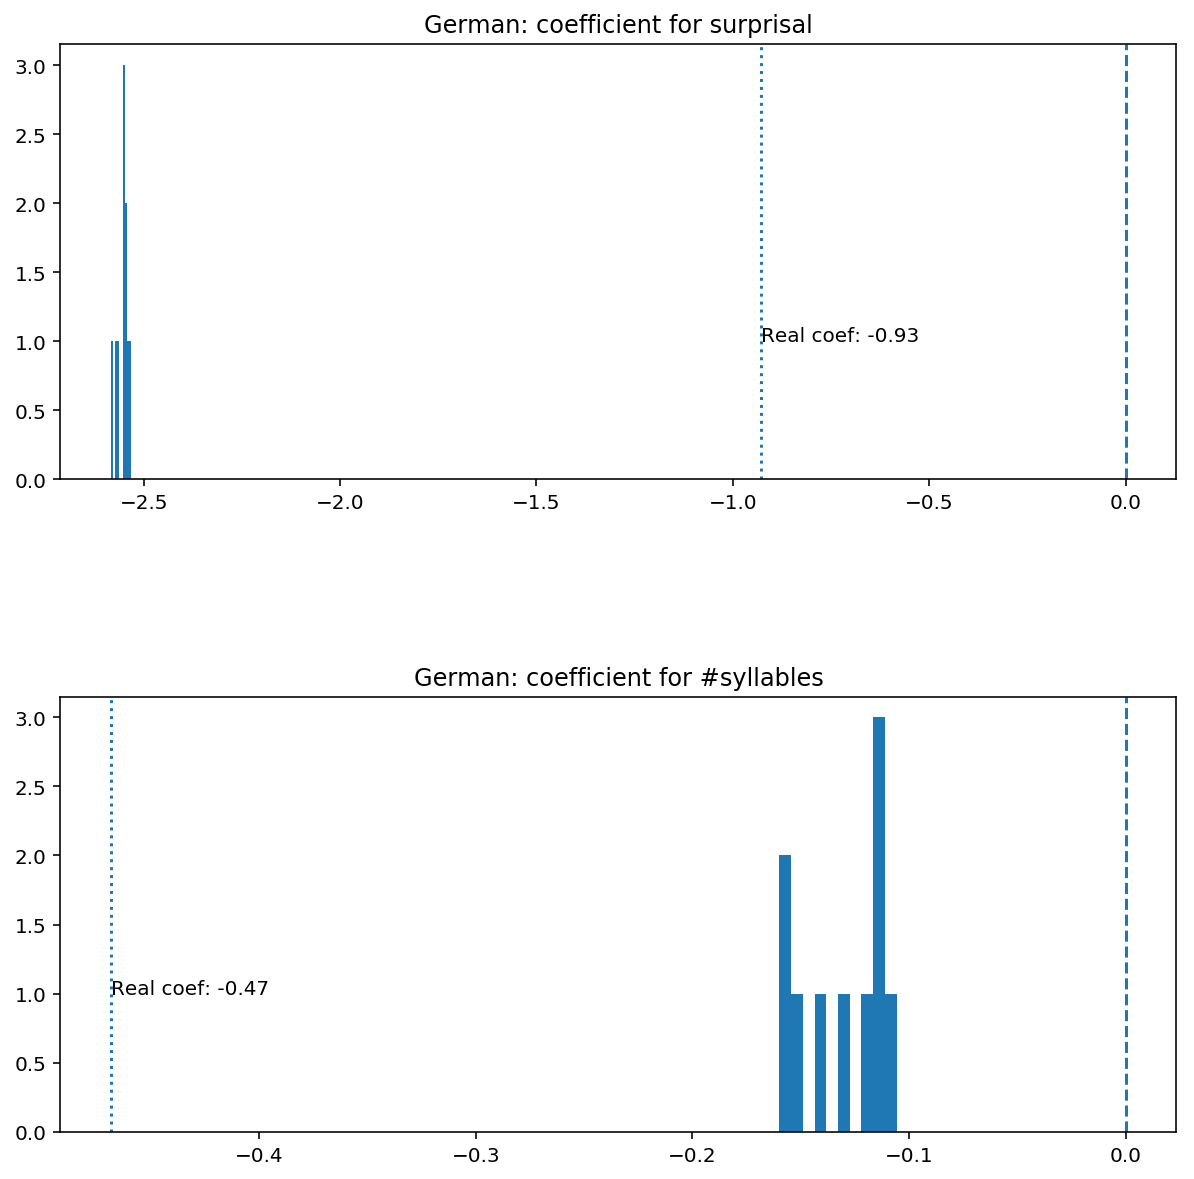

In [23]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [38]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'num_homophones'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    # '#homophones'
]
LANGUAGE = 'German'

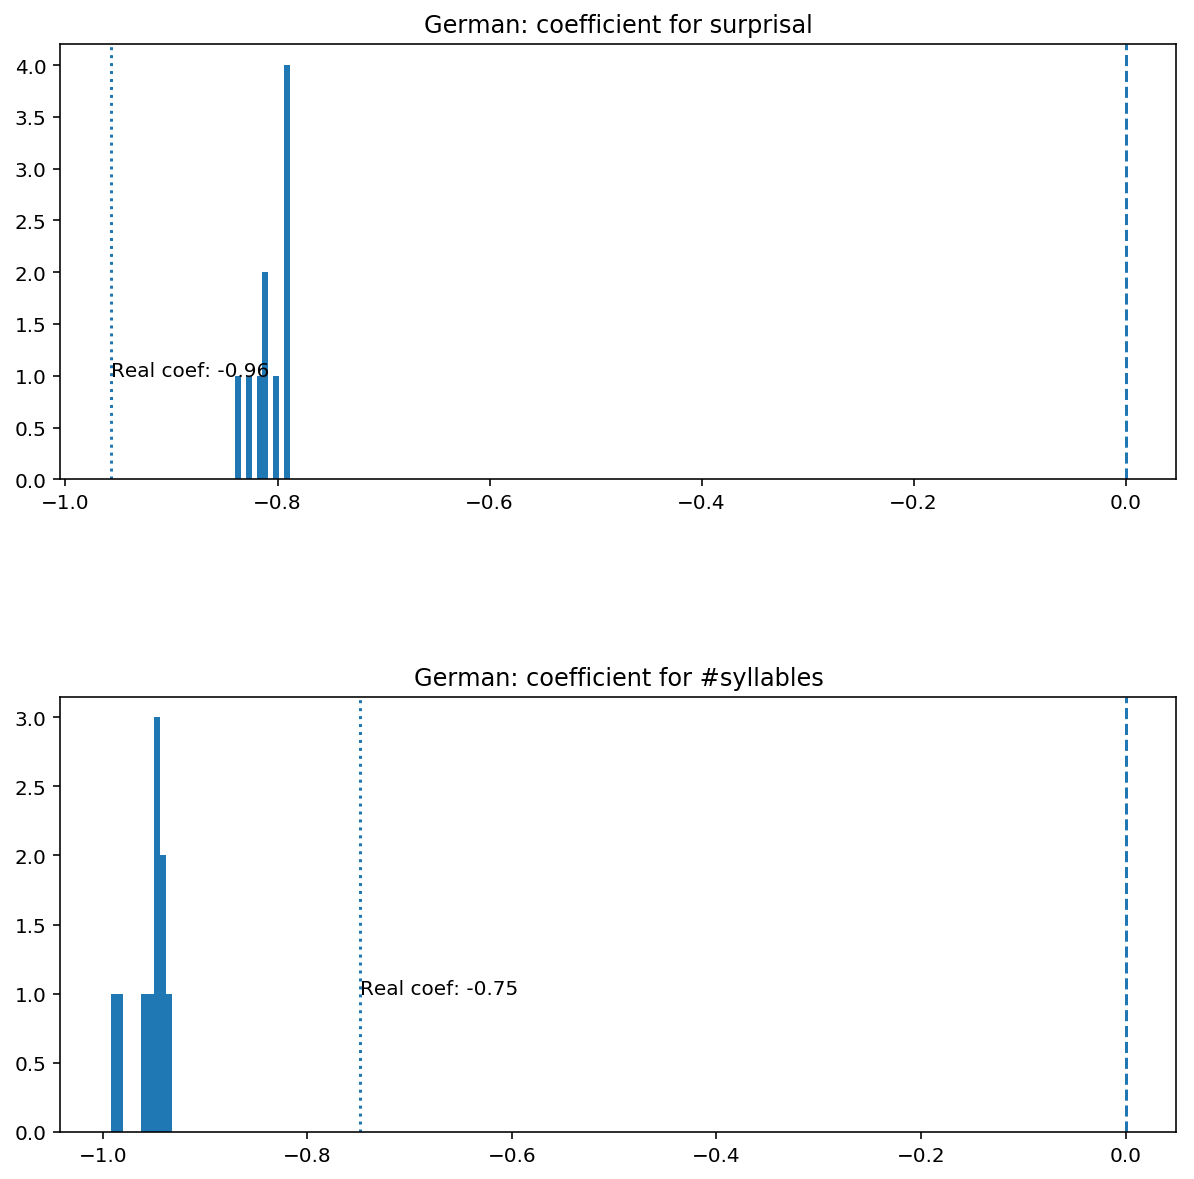

In [39]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Dutch

In [24]:
df_celex, df_celex_processed, df_dutch_artificials = load_lexicons_for_language("dutch")

In [25]:
len(df_celex)

67910

In [26]:
len(df_celex_processed)

65351

In [27]:
df_dutch_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [28]:
info_for_dutch = process_and_extract_artificials(df_dutch_artificials)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [29]:
processed_artificials = info_for_dutch['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

In [ ]:
plot_real_vs_art(info_for_dutch['mean_mp'], df_dutch_stats['mean_mp'],
                'Mean #minimal pairs', language="Dutch")

In [ ]:
plot_real_vs_art(info_for_dutch['mean_mp_w_hp'], df_dutch_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Dutch")

In [ ]:
plot_real_vs_art(info_for_dutch['max_mp'], df_dutch_stats['max_mp'],
                'Max neighborhood size', language="Dutch")

In [ ]:
plot_real_vs_art(info_for_dutch['max_mp_w_hp'], df_dutch_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Dutch")

In [ ]:
plot_real_vs_art(info_for_dutch['total_mp'], df_dutch_stats['total_mp'],
                'Total #minimal pairs', language='Dutch')

In [ ]:
plot_real_vs_art(info_for_dutch['total_mp_w_hp'], df_dutch_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Dutch')

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

In [ ]:
plot_real_vs_art(info_for_dutch['homophone_percentages'], df_dutch_stats['homophone_percentage'],
                '%homophonous wordforms', language='Dutch')
plt.savefig("Figures/dutch/dutch_%_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_dutch['mean_homophones'], df_dutch_stats['mean_homophones'],
                'Mean #homophones per word', language='Dutch')
plt.savefig("Figures/dutch/dutch_mean_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_dutch['max_homophones'], df_dutch_stats['max_homophones'],
                'Max #homophones', language='Dutch')
plt.savefig("Figures/dutch/dutch_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (Dutch)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [48]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'Dutch'

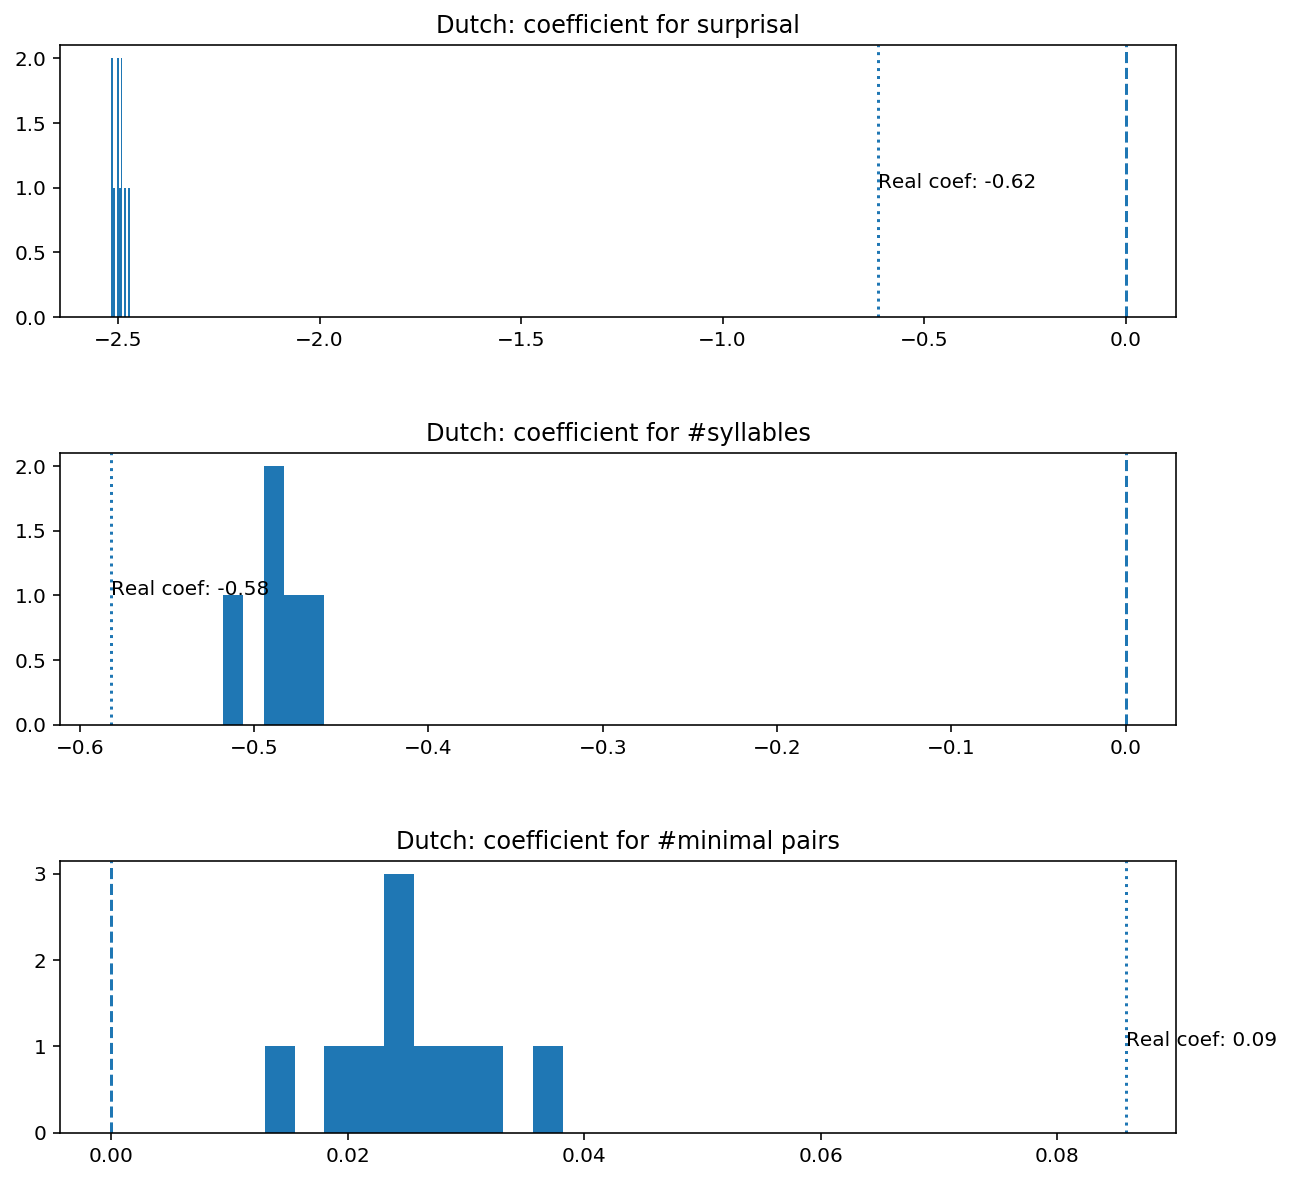

In [49]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [50]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'Dutch'

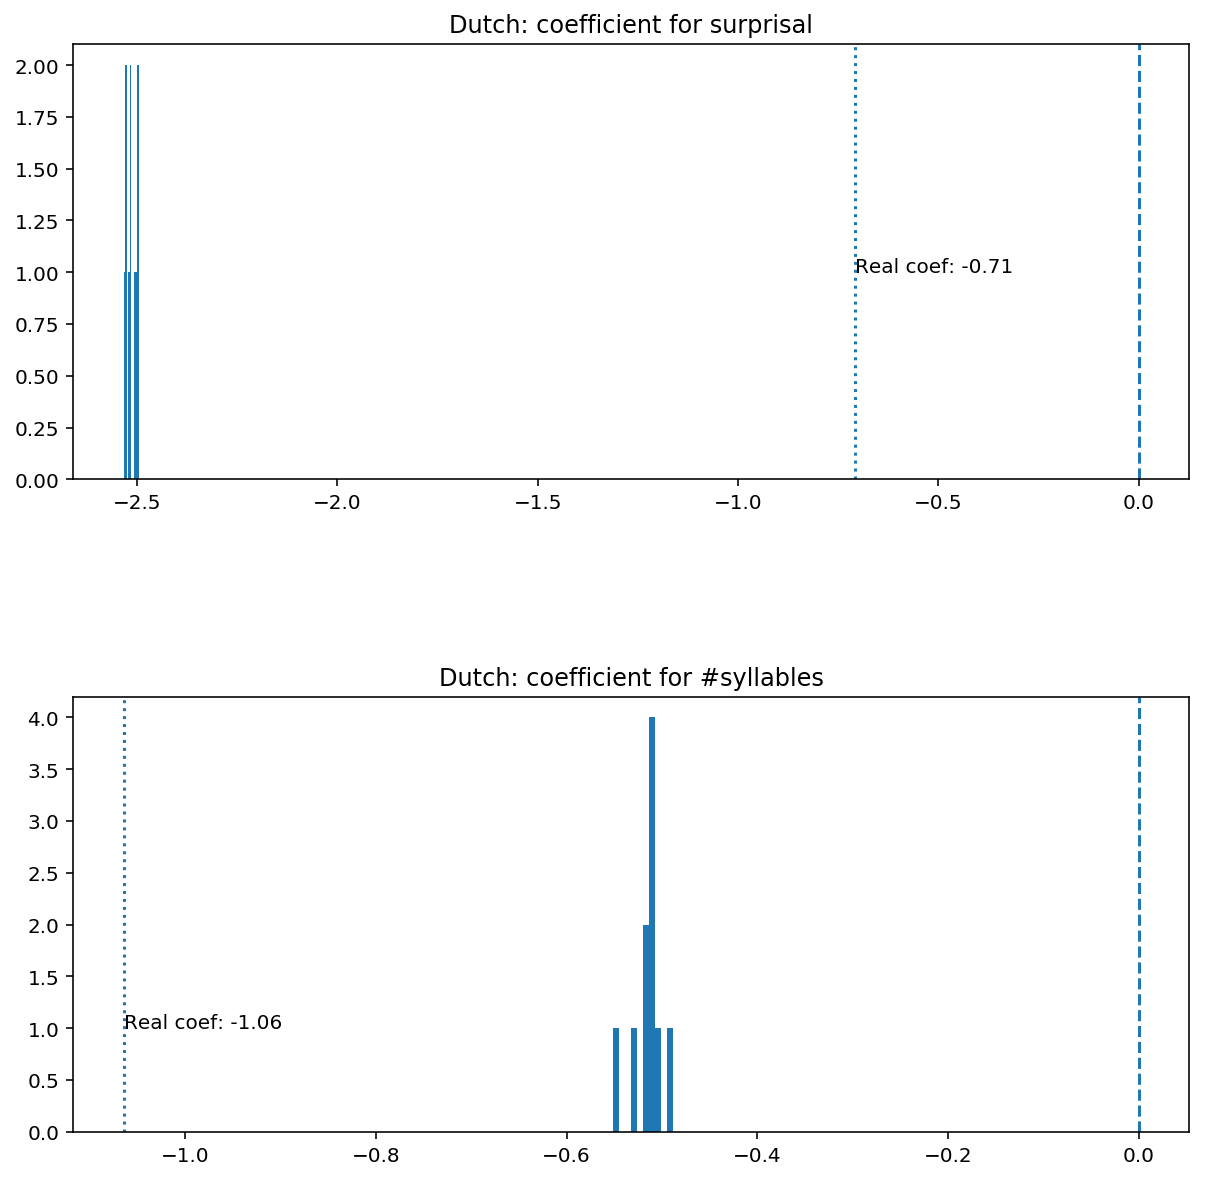

In [51]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

**TO DO: Running into singular matrix problems here.**

#### Analysis

In [30]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
]
LANGUAGE = 'Dutch'

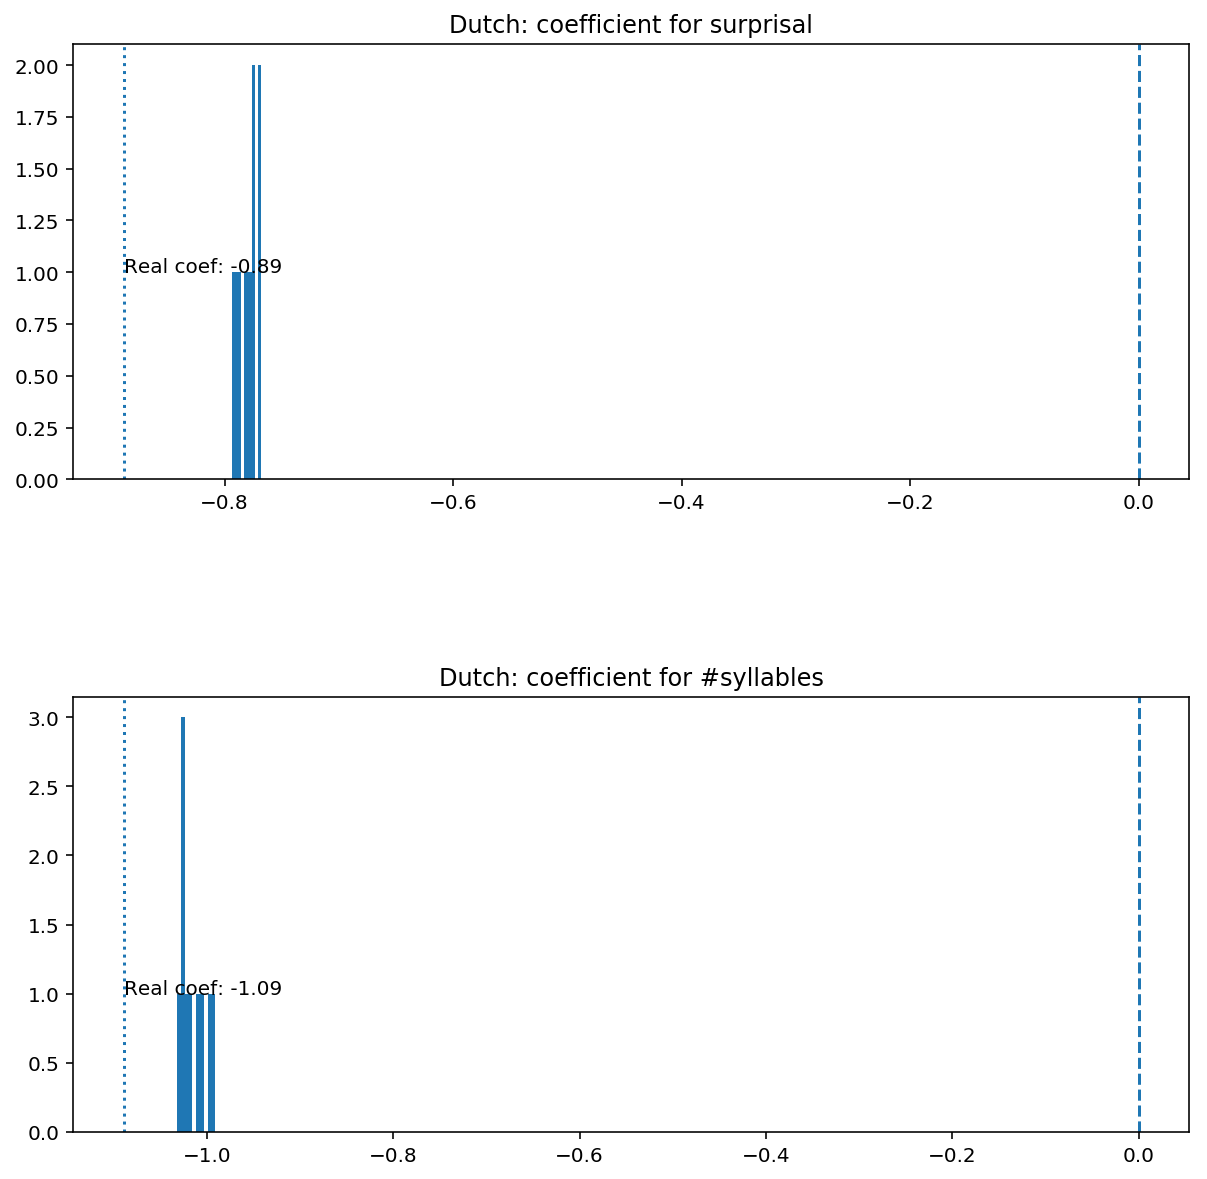

In [31]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# French

In [32]:
import src.config as config

In [33]:
df_celex, df_celex_processed, df_french_artificials = load_lexicons_for_language("french", 
                                                                                word_column=config.WORD_COLUMN['french'], 
                                                                                phon_column=config.PHON_COLUMN['french'])

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [34]:
len(df_celex)

47310

In [35]:
len(df_celex_processed)

37278

In [36]:
df_french_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [37]:
info_for_french = process_and_extract_artificials(df_french_artificials)

100%|██████████| 10/10 [00:09<00:00,  1.22it/s]


In [38]:
processed_artificials = info_for_french['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

In [ ]:
plot_real_vs_art(info_for_french['mean_mp'], df_french_stats['mean_mp'],
                'Mean #minimal pairs', language="French")

In [ ]:
plot_real_vs_art(info_for_french['mean_mp_w_hp'], df_french_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="French")

In [ ]:
plot_real_vs_art(info_for_french['max_mp'], df_french_stats['max_mp'],
                'Max neighborhood size', language="French")

In [ ]:
plot_real_vs_art(info_for_french['max_mp_w_hp'], df_french_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="French")

In [ ]:
plot_real_vs_art(info_for_french['total_mp'], df_french_stats['total_mp'],
                'Total #minimal pairs', language='French')

In [ ]:
plot_real_vs_art(info_for_french['total_mp_w_hp'], df_french_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='French')

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

In [ ]:
plot_real_vs_art(info_for_french['homophone_percentages'], df_french_stats['homophone_percentage'],
                '%homophonous wordforms', language='French')
plt.savefig("Figures/french/french_%_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_french['mean_homophones'], df_french_stats['mean_homophones'],
                'Mean #homophones per word', language='French')
plt.savefig("Figures/french/french_mean_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_french['max_homophones'], df_french_stats['max_homophones'],
                'Max #homophones per word', language='French')
plt.savefig("Figures/french/french_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (French)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in the artificial lexicons than real lexicon (as shown in English, when controlling for neighborhood size).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [62]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'French'

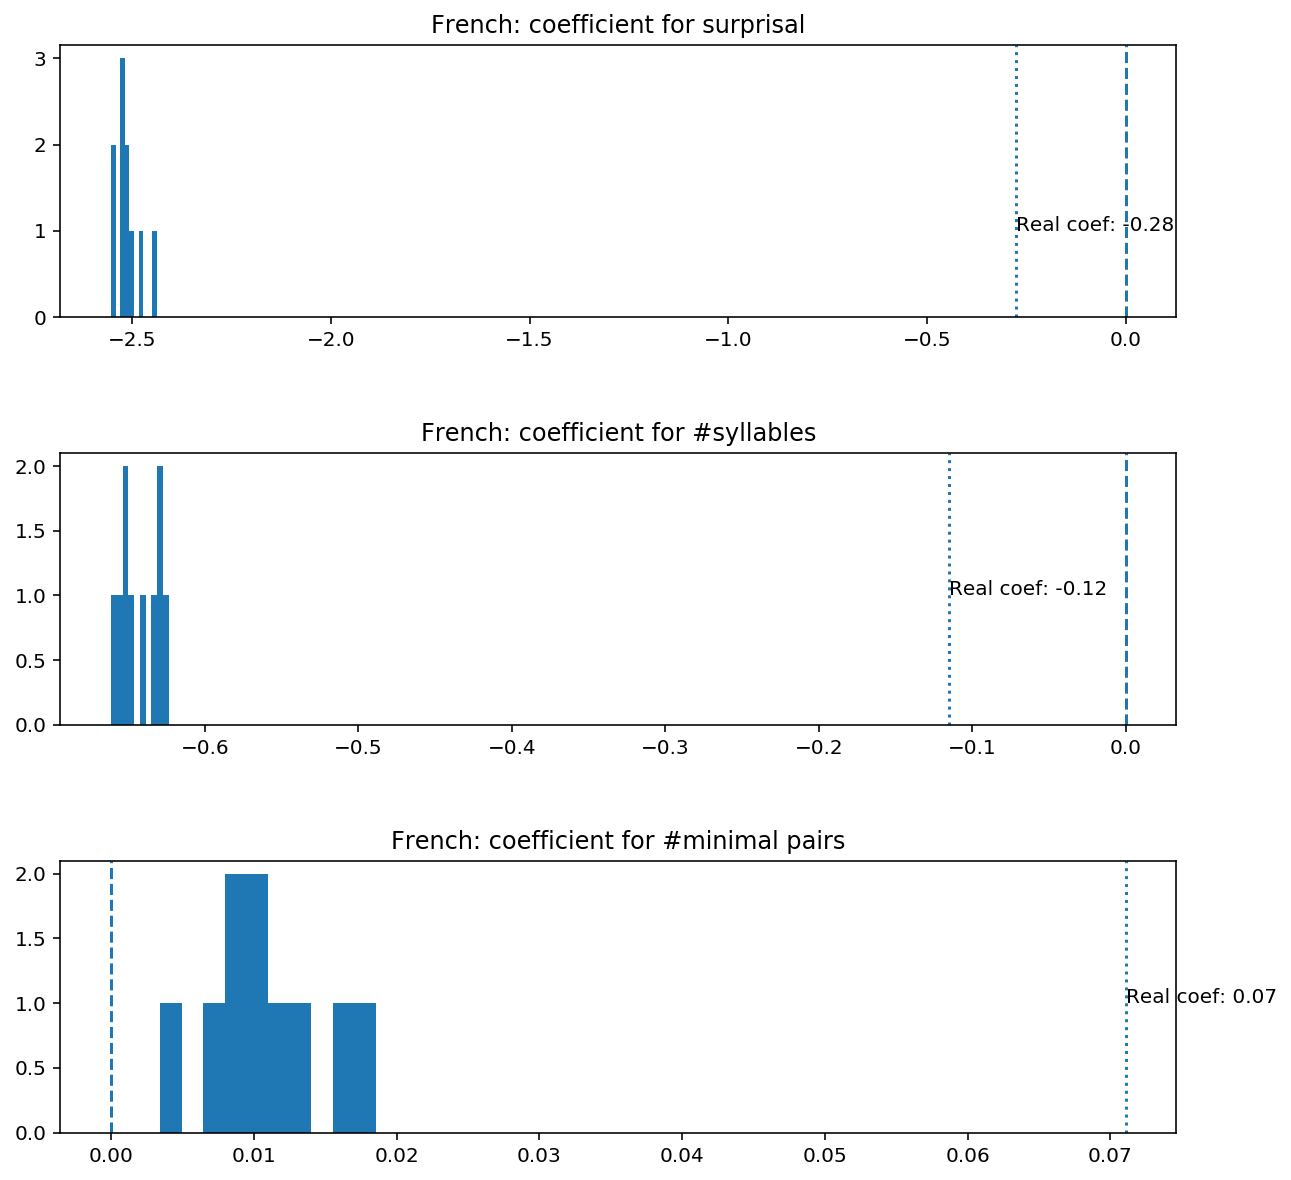

In [63]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [59]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'French'

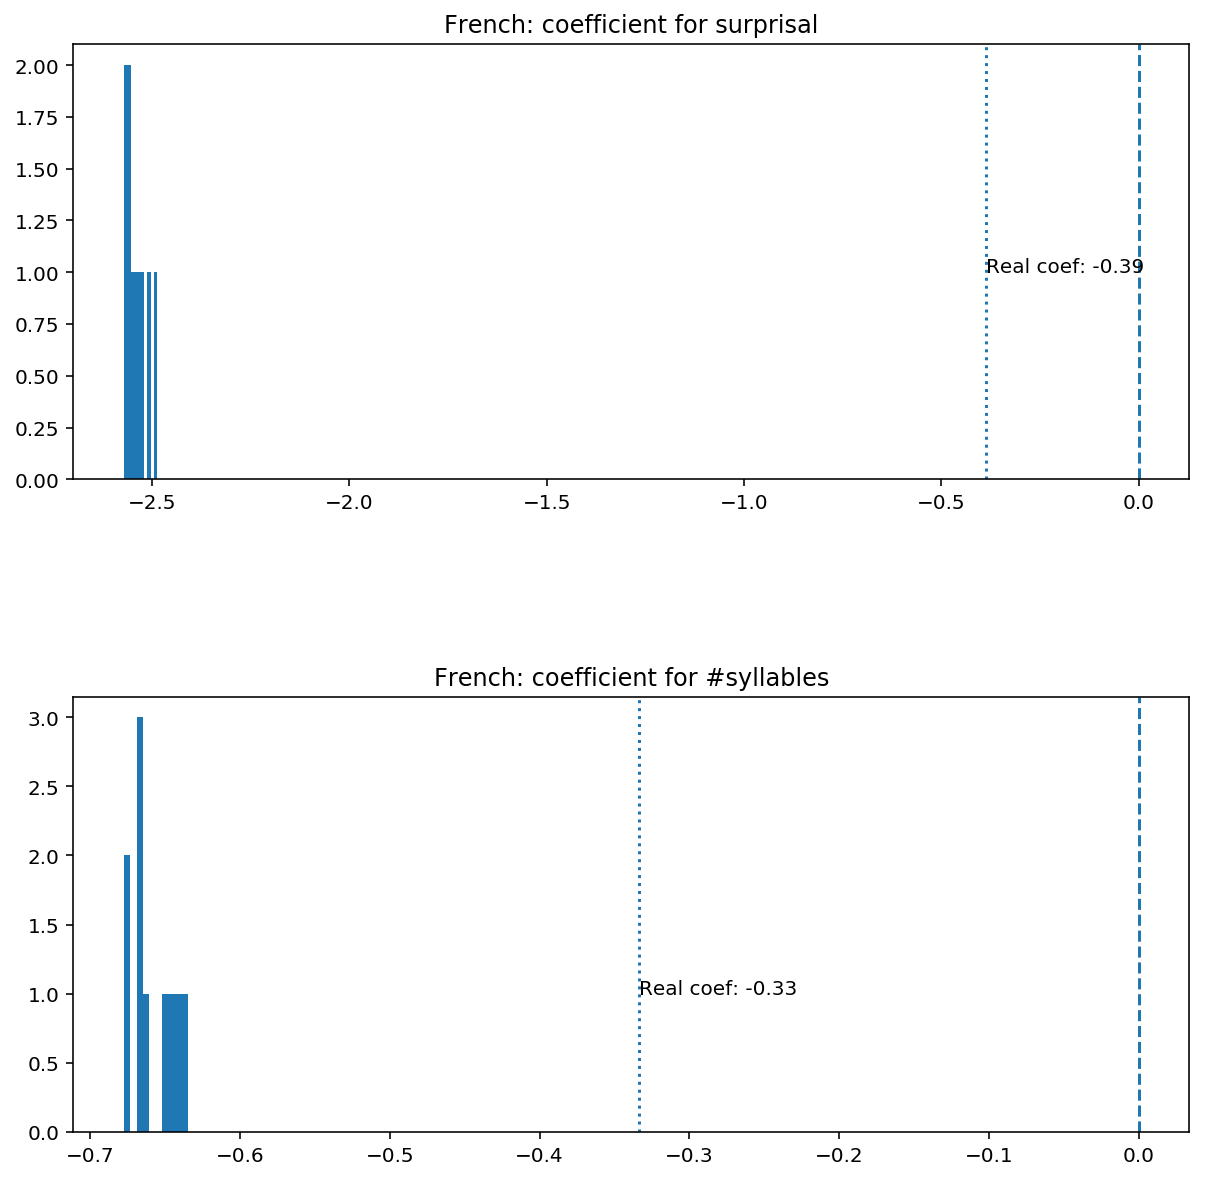

In [60]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [39]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#syllables', 
]
LANGUAGE = 'French'

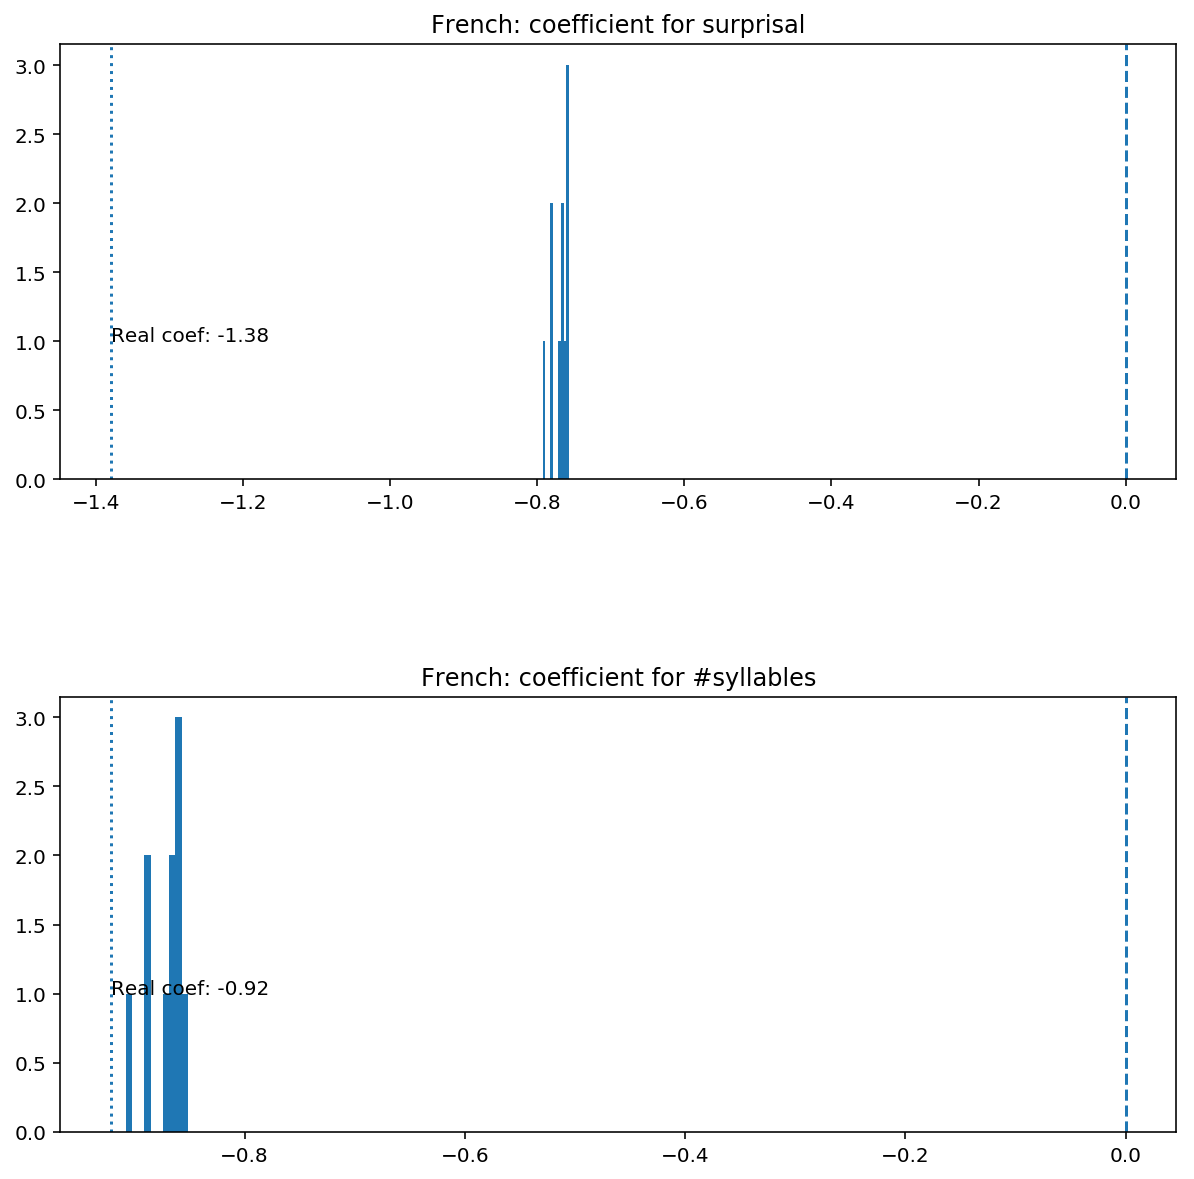

In [40]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

## Japanese

In [41]:
df_celex, df_celex_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

In [42]:
len(df_celex)

51147

In [43]:
len(df_celex_processed)

40449

In [44]:
df_japanese_stats = get_stats_for_lexicon(df_celex_processed)
df_japanese_stats

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33,
 'mean_mp': 3.9055,
 'max_mp': 43,
 'total_mp': 157972,
 'mean_mp_w_hp': 7.6132,
 'max_mp_w_hp': 273,
 'total_mp_w_hp': 307946}

### Preprocess artificials

In [45]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.30it/s]


In [46]:
processed_artificials = info_for_japanese['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

In [ ]:
plot_real_vs_art(info_for_japanese['mean_mp'], df_japanese_stats['mean_mp'],
                'Mean #minimal pairs', language="Japanese")

In [ ]:
plot_real_vs_art(info_for_japanese['mean_mp_w_hp'], df_japanese_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Japanese")

In [ ]:
plot_real_vs_art(info_for_japanese['max_mp'], df_japanese_stats['max_mp'],
                'Max neighborhood size', language="Japanese")

In [ ]:
plot_real_vs_art(info_for_japanese['max_mp_w_hp'], df_japanese_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Japanese")

In [ ]:
plot_real_vs_art(info_for_japanese['total_mp'], df_japanese_stats['total_mp'],
                'Total #minimal pairs', language='Japanese')

In [ ]:
plot_real_vs_art(info_for_japanese['total_mp_w_hp'], df_japanese_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Japanese')

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

In [ ]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 100, in some cases) than the real lexicon (below ~30-40). There is also a higher number of *mean* homophones per word.

In [ ]:
plot_real_vs_art(info_for_japanese['homophone_percentages'], df_japanese_stats['homophone_percentage'],
                '%homophonous wordforms', language='Japanese')
plt.savefig("Figures/japanese/japanese_%_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_japanese['mean_homophones'], df_japanese_stats['mean_homophones'],
                'Mean #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_mean_homophones.png", dpi=300)

In [ ]:
plot_real_vs_art(info_for_japanese['max_homophones'], df_japanese_stats['max_homophones'],
                'Max #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_max_homophones.png", dpi=300)

## Statisical Analysis

### Predicting number of homophones

#### Analysis

In [16]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#morae', 
    # '#minimal pairs'
]
LANGUAGE = 'Japanese'

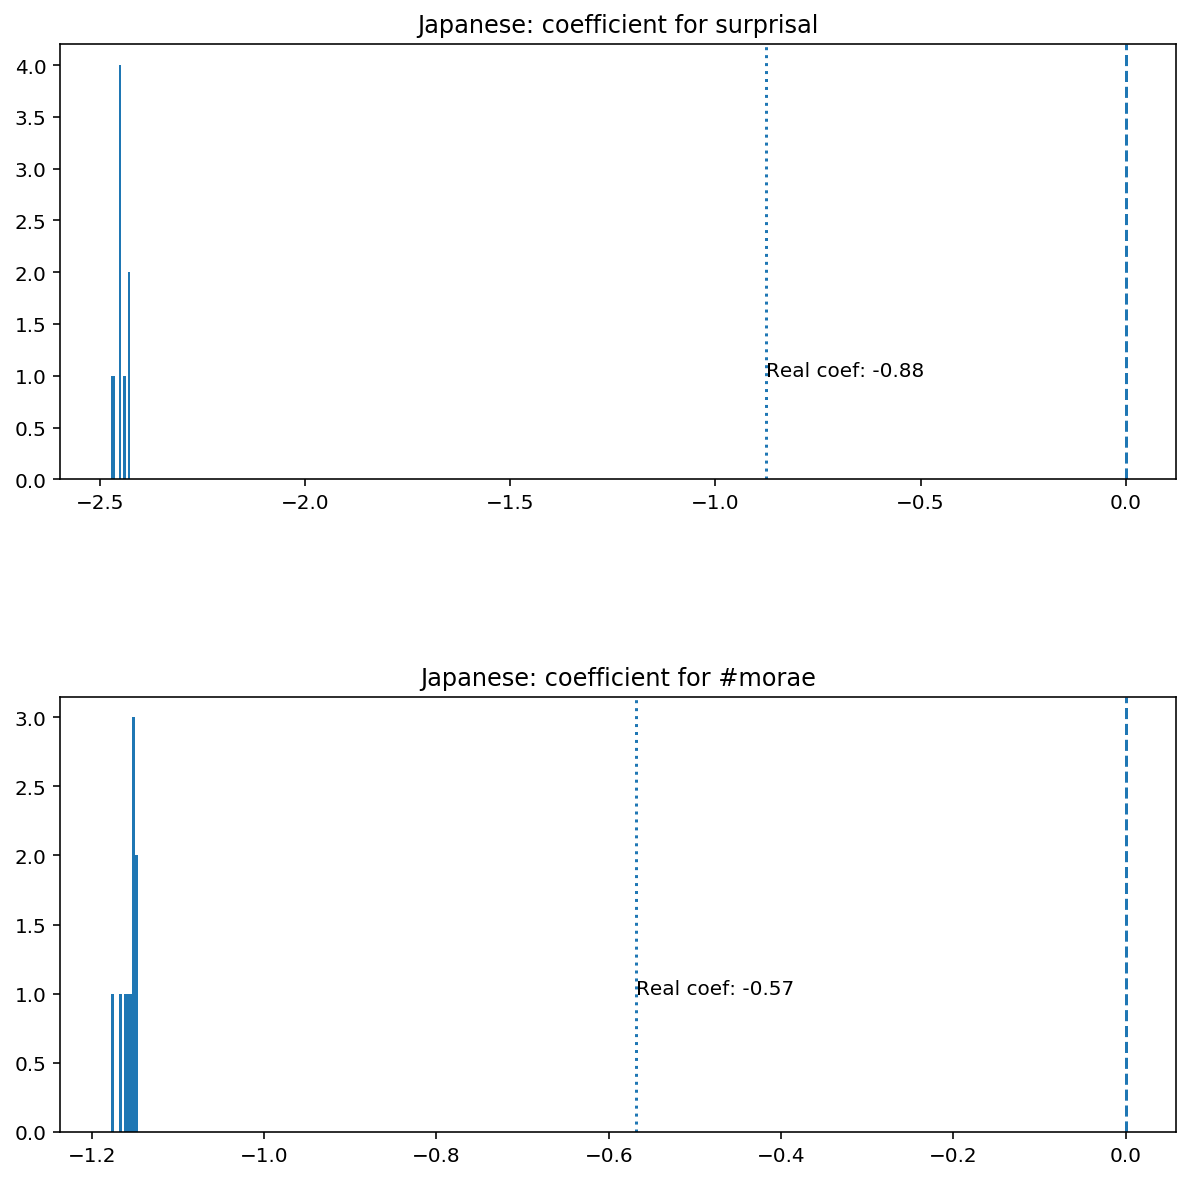

In [17]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [18]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#morae', 
    '#minimal pairs'
]
LANGUAGE = 'Japanese'

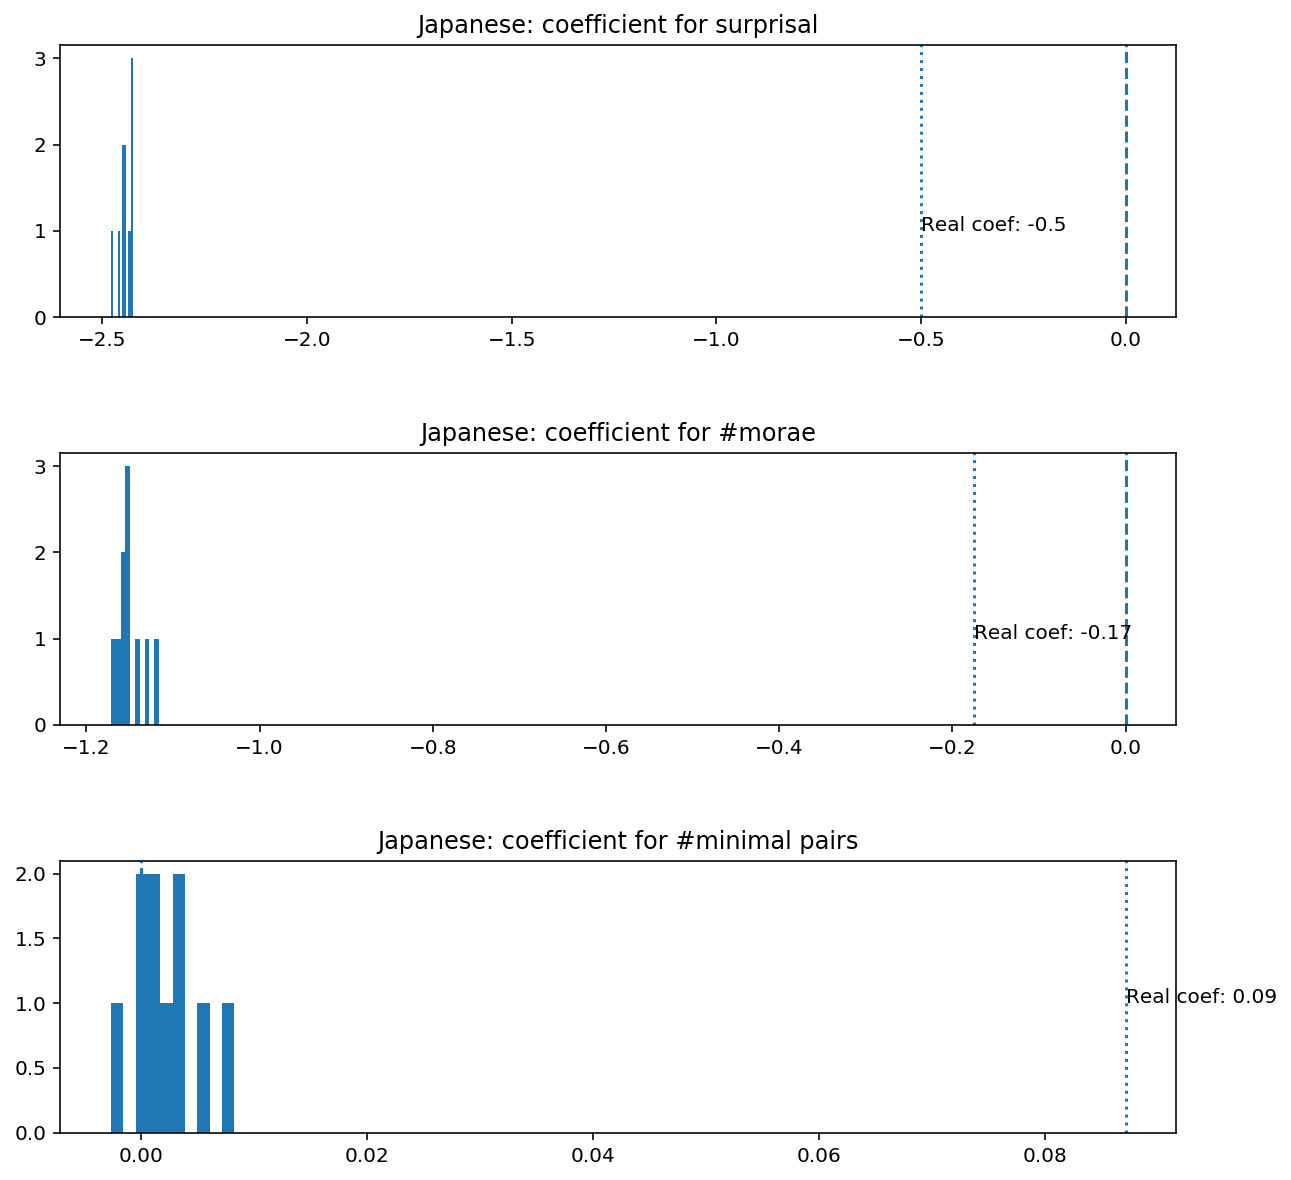

In [19]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size

The effect of `surprisal` is larger in the **real** than **artificial** lexicons: the real Japanese lexicon appears to optimize neighborhoods more on the basis of surprisal than artificial lexicons.

The effect of `#morae` is smaller in the **real** than **artificial** lexicon: the artificial lexicons optimize neighborhoods more on the basis of word length than the real lexicon.

And the effect of `#homophones` is larger (in the expected direction) in the **real**  than the **artificial** lexicons: wordforms with more homophones also have larger neighborhoods. This isn't true in the artificial lexicon.

#### Analysis

In [47]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'surprisal', 
    '#morae', 
]
LANGUAGE = 'Japanese'

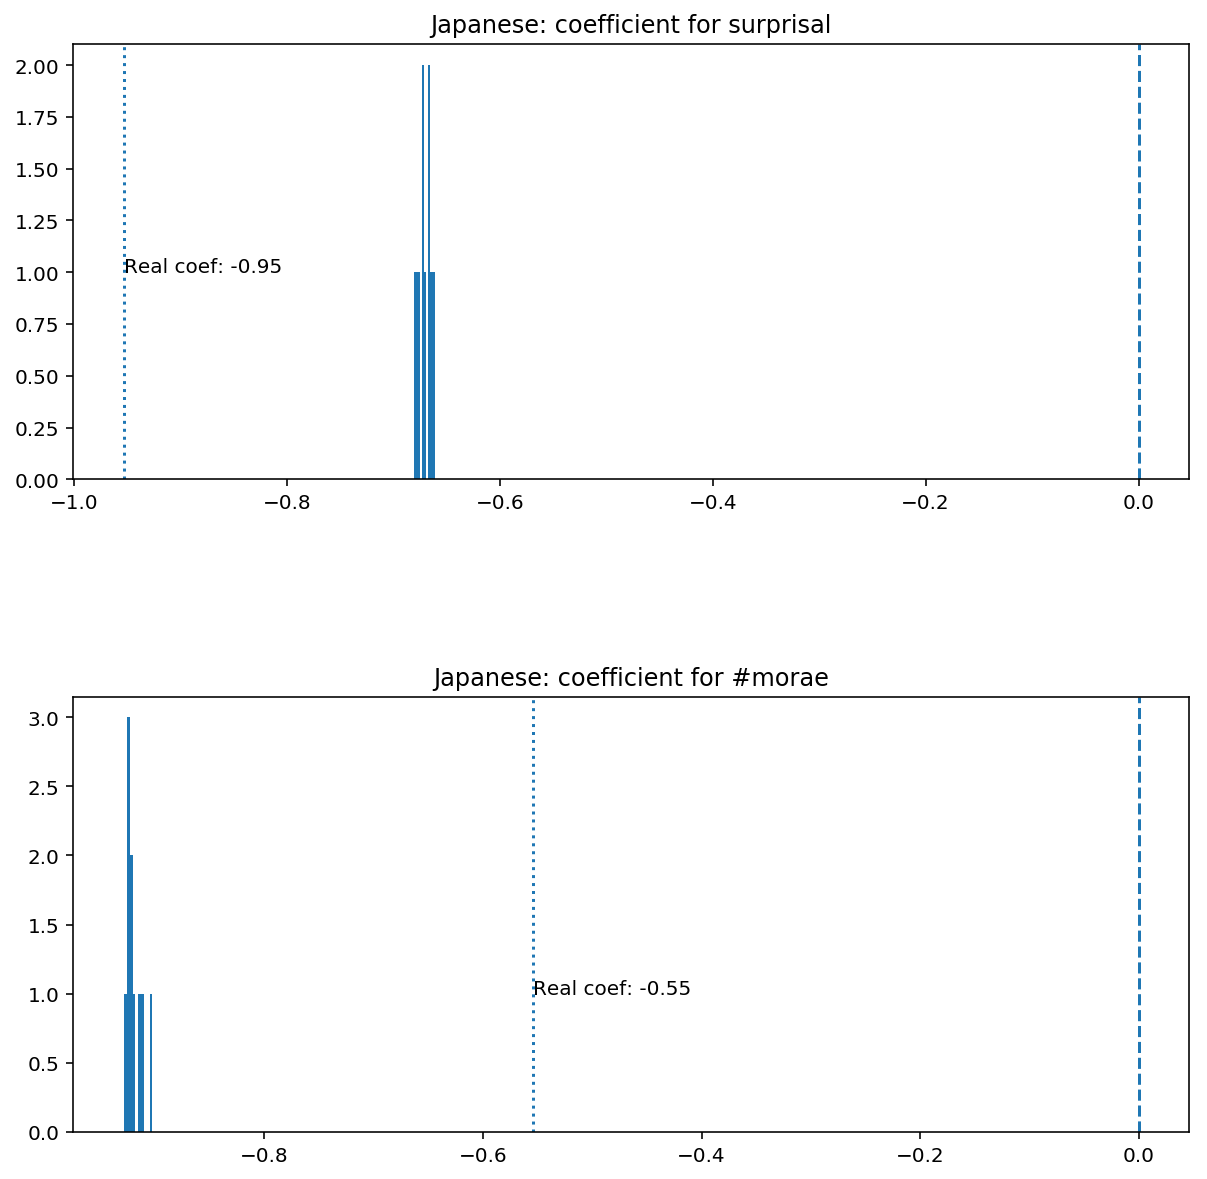

In [48]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Discussion

The central question in this analysis was whether the relationship between a word's **neighborhood size** and the **number of homophones** that this word has is larger in the real lexicon, or in artificial lexicons matched for length and phonotactic plausibility.

More broadly, we were interested in comparing distributional features of neighborhood sizes and homophony across these kinds of lexicons. 

Below, we discuss the results.
 

## Descriptive Results

### Neighborhood size

Consistent with [Dautriche et al (2016)](https://www.sciencedirect.com/science/article/pii/S0010027717300331), the real lexicons contained larger neighborhoods (e.g. more minimal pairs) overall. 

Words from the real lexicons had more minimal pairs on average, as well as a larger *maximum* number of minimal pairs, than words from the artificial lexicons. The only case in which this wasn't true was when neighborhood size was calculated *including* homophones; in these cases, maximum neighborhood size was larger for artificial, as opposed to real, lexicons. This is to be expected, considering that the artificial lexicons had a very high density of homophones overall.

In other words, the real lexicons are "clumpier" than the artificial lexicons. 

### Homophony

In all lexicons, artificial lexicons had a higher number of possible homophones *per word* than the real lexicon. The maximum number of homophones per word in English is ~7 (~4 in German, ~11 in French, ~5 in Dutch), whereas in the artificial lexicons, some wordforms enjoyed upwards of ~70 (~40 in German, ~150 in Dutch, ~60 in French) different entries.

The key difference across the 4 languages was that the artificial English and French lexicons had a *lower* proportion of homophonous wordforms than the real counterparts; whereas the German and Dutch artificial lexicons had a *higher* proportion of homophonous wordforms than the real counterparts.

In other words, both artificial lexicons permitted more recycling of particular lexical items, even though the *real* English and French lexicons allowed more homophony overall.

This raises the question: how are homophones **distributed** in the real vs. artificial lexicons?


** TO DO: Update reporting here **

## Results from Statistical Modeling

We also examined the relationship between **#homophones** of a word and its **phonotactic plausibility** (e.g. *surprisal*), **number of syllables**, and its **neighborhood size**. 

### Homophony

In both languages, *surprisal* predicts *#homophones* better in the artificial lexicons than in the real lexicons. In other words, the artificial lexicons actually "recycle" phonotactically-plausible words more than the real lexicon.

In English, *#syllables* better predicts *#homophones* better in the artificial lexicon than real lexicons. The reverse is seen for German. Why?

And critically, in both lexicons, *neighborhood size* predicts *#homophones* better in the real lexicon than in the artificial lexicon. In other words, homophones distribute in a predictive, positive way with larger neighborhoods in both English and German––whereas in artificial lexicons modeled on both languages, an increased number of homophones is not necessarily more likely in larger neighborhoods.


### Neighborhood size


In both languages, *surprisal* predicts *neighborhood size* better in the real lexicon than the artificial lexicons. In other words, larger neighborhoods are more "driven" by a pressure for phonotactic plausibility in actual English and German.

A disparate result across languages is observed for *#syllables*. *Neighborhood size* is better predicted by *#syllables* in the real English lexicon, but not in the real German lexicon. Why?

And critically, in both lexicons, *#homophones* predicts *neighborhood size* better in the real lexicon  than in the artificial lexicons. In other words, where there are more homophones in English and German, there are more likely to be larger neighborhoods. This is truer for real lexicons than artificial lexicons.


## Interpretation

Despite some different results across English and German/Dutch with respect to the real vs. artificial lexicons (e.g. the % of homophonous wordforms overall, and the role of *#syllables* in predicting *#homophones* or *neighborhood size*), they both exhibit an intriguing dissociation when it comes to patterns of **homophony** vs. patterns of **neighborhood size**. 

The artificial lexicons appear to place a stronger selection pressure on optimizing **homophony** for easy (e.g. phonotactically-plausible) word-forms. The artificial lexicons display a much larger "cap" on the number of meanings assigned to a wordform (40-60 vs. 4-7), and a stronger relationship between the number of homophones a word has and its phonotactic plausibility. 

In contrast, the real lexicons appear to place a stronger selection pressure on optimizing **neighborhood size** for easy (e.g. phonotactically-plausible) word-forms. The real lexicons display larger neighborhoods overall, and a stronger relationship between neighborhood size and phonotactic plausibility.

What does this mean? One interpretation draws inspiration from [Piantadosi et al (2012)](https://www.sciencedirect.com/science/article/pii/S0010027711002496), which argues that languages optimize for efficiency by recycling easy wordforms. We suggest that this could be true, but that real lexicons exhibit a much sharper "cap" on the extent to which any given wordform can be recycled. That is, real lexicons don't recycle wordforms to the extent that artificial lexicons do––potentially to avoid, or otherwise reduce, unmanageable levels of lexical ambiguity (E.g. >40 distinct meanings per wordform). Instead, real lexicons might optimize for efficiency by using similar––but not identical––"easy" wordforms, generating larger neighborhoods overall, and exhibiting stronger relationships between neighborhood size and phonotactic plausibility. Occasionally, this pressure produces homophones as well, and these homophones should be most likely to be found in larger neighborhoods; this prediction is also borne out in the data.

tl;dr: Real lexicons are driven by competing pressures to **recycle** efficient wordforms, and **avoid** ambiguity. This creates a trade-off between lexical ambiguity (homophones) and signal ambiguity (clumpiness). Real lexicons settle somewhere in between.  